In [1]:
reset -fs

In [2]:
#######################
# standard code block #
#######################

# see https://ipython.readthedocs.io/en/stable/interactive/magics.html
#%pylab inline

# sets backend to render higher res images
#%config InlineBackend.figure_formats = ['retina']

#######################
#       imports       #
#######################
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import pandas as pd
import numpy as np
import pickle
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow import keras

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, InputLayer
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import mobilenet_v2, VGG16




In [3]:
import matplotlib.image as mpimg
from tensorflow.keras import datasets, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array



In [4]:
img_size = 48

In [5]:
data_df = pd.read_csv('https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/3364/31151/compressed/icml_face_data.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1638486722&Signature=hAGe5n0%2BG%2F1K4jNjYKM9VW5U26w41MCwDJgeyI4IWVyq0T9kA2t6lEVQKKqB7Ru7lnfjZ6VvWHwfkwSRjMFfS8Rwrp63lty05joF0SCZZKuXsvn70QoyBB%2Fa43iR2vUKEITJz8tnWilbrK5Hpn2n93JBU0oVN0bZqRyh1e25Z4C6rj3vEWl2vx79VgfImqExOA4h9lpg%2BMkOLrLue9DCiJy%2BzrAT%2FC39MN8b4%2B6quFH8H5mMwGgbJP%2FgLtu0UYCMqC1MEqrb5yVXnnztEyt50LX%2FvG4i1M8PWoxqMunrEK8Y%2FIBNfhDAfGtaZmnkBJKUlwGA9eukOVRhAxk78Y92Iw%3D%3D&response-content-disposition=attachment%3B+filename%3Dicml_face_data.csv.zip')
print(data_df.shape)

(35887, 3)


In [6]:
data_df

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


### **Distribution of the entire dataset**

In [7]:
counts = data_df['emotion'].value_counts().to_dict()
print(counts)

{3: 8989, 6: 6198, 4: 6077, 2: 5121, 0: 4953, 5: 4002, 1: 547}


In [8]:
def plot_distribution(counts_dict, labels):
  sd_counts_dict = {k : counts_dict[k] for k in sorted(counts_dict)}

  keys = sd_counts_dict.keys()
  values = sd_counts_dict.values()

  plt.figure(figsize=[8,6])
  plt.bar(keys, values, tick_label=labels)
  plt.title('Emotion Label Counts')
  plt.grid(b=None)
  plt.show();

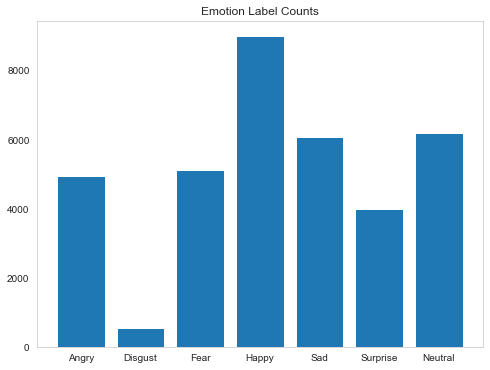

In [9]:
counts_dict = data_df['emotion'].value_counts().to_dict()
emotions = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

plot_distribution(counts_dict, emotions)

### **Reclassify the dataset to Not Happy:0/ Happy:1 / Neutral:2**

Orignal data containst seven categories
0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

Using the data and classified the images into 3 categories. 
Since Surprise may means happy surpirse or unhappy surprise, this may make the computer get confused. Therefore, we remove the Surprise data and change the Angry, Disgust, Fear and Sad into unhappy category. New category & annotation
- Not Happy (from Angry, Disgust, Fear and Sad): 0
- Happy: 1
- Neutral: 2

In [10]:
# remove the surprise data
data_df = data_df[data_df['emotion'] !=5]

In [11]:
# reclassify the images to unhappy:0/ happy:1/ neutral:2
data_df['emotion_new']  = [ 1 if x==3 else ( 2 if x==6 else 0) for x in data_df.emotion]

<ipython-input-11-5e7d0baf0bd5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['emotion_new']  = [ 1 if x==3 else ( 2 if x==6 else 0) for x in data_df.emotion]


In [12]:
data_df.emotion_new.value_counts()

0    16698
1     8989
2     6198
Name: emotion_new, dtype: int64

In [13]:
data_df.head(5)

,emotion,Usage,pixels,emotion_new
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,0
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...,0
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...,0
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,0
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,2


In [14]:
data_df.columns= data_df.columns.str.replace(' ', '')

In [15]:
data_df.Usage.value_counts()

Training       25538
PublicTest      3174
PrivateTest     3173
Name: Usage, dtype: int64

In [16]:
counts_dict = data_df['emotion_new'].value_counts().to_dict()
sd_counts_dict = {k : counts_dict[k] for k in sorted(counts_dict)}
sd_counts_dict

{0: 16698, 1: 8989, 2: 6198}

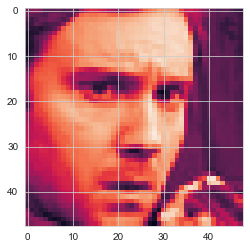

In [17]:
plt.imshow(np.array(data_df.iloc[0]['pixels'].split(' ')).reshape(48, 48).astype('float32') )

In [18]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion_new'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48)) / 255.0
        image_array[i] = image
    
    image_array = image_array.reshape((-1, 48, 48, 1))
    return image_array, image_label

In [19]:
X_train, y_train = prepare_data(data_df[data_df['Usage']=='Training'])
X_val, y_val = prepare_data(data_df[data_df['Usage']=='PrivateTest'])
X_test, y_test = prepare_data(data_df[data_df['Usage']=='PublicTest'])

y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

In [20]:
#data_df['img'] = data_df['pixels'].apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))


In [21]:
print(y_train.shape[0])
print(y_val.shape[0])
print(y_test.shape[0])

25538
3173
3174


total train items:25538


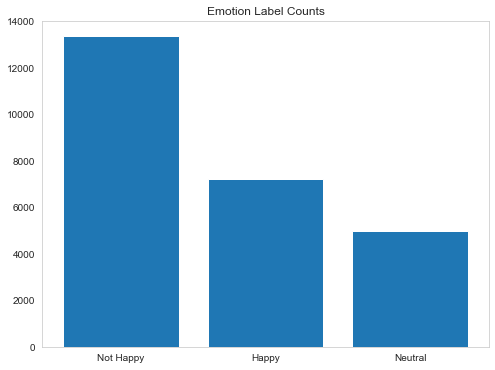

In [22]:
counts_dict = pd.DataFrame(y_train, columns=['emotion'])['emotion'].value_counts().to_dict()
emotions = ['Not Happy','Happy','Neutral']
print(f"total train items:{y_train.shape[0]}")
plot_distribution(counts_dict, emotions)

total Test items:3174


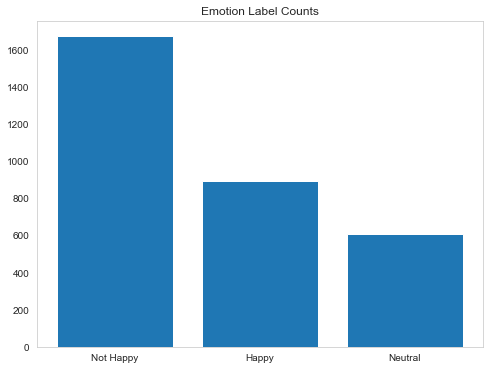

In [23]:
counts_dict = pd.DataFrame(y_test, columns=['emotion'])['emotion'].value_counts().to_dict()
emotions = ['Not Happy','Happy','Neutral']
print(f"total Test items:{y_test.shape[0]}")
plot_distribution(counts_dict, emotions)

In [24]:
# X_train, y_train = train_df[['img', 'pixels']],  train_df['emotion_new']
# X_test, y_test = test_df['img'],  test_df['emotion_new']
# y_train_cat = to_categorical(y_train)
# y_test_cat = to_categorical(y_test)
# print(f"shape X_train: {X_train.shape}, y_train: {y_train.shape} ")
# print(f"shape X_test: {X_test.shape}, y_train: {y_test.shape} ")

In [25]:
X_train[0].shape

(48, 48, 1)

In [34]:
data_df.emotion_new.nunique()

3

In [43]:
emotion_cat = {0:'unhappy', 1:'happy', 2:'neutral'}
emotion_cat

{0: 'unhappy', 1: 'happy', 2: 'neutral'}

In [46]:
y_train_df = pd.DataFrame(y_train, columns=['emotion'])

In [50]:
test = y_train_df[y_train_df['emotion']==0].index
test

Int64Index([    0,     1,     2,     3,     5,     6,     9,    10,    16,
               18,
            ...
            25525, 25526, 25530, 25531, 25532, 25533, 25534, 25535, 25536,
            25537],
           dtype='int64', length=13358)

3

In [90]:
data_df.emotion_new.nunique()

3

In [103]:
def plot_all_emotions(img_num=3):
    fig, axs = plt.subplots(len(emotion_cat), img_num, figsize=(8,8))
    axs = axs.ravel()
    pos=0
    for emotion in range(data_df.emotion_new.nunique()):
        idx_arr = y_train_df[y_train_df['emotion']==emotion].index
        for img_idx in range(img_num):
            idx = idx_arr[img_idx]
            axs[pos].imshow(X_train[idx][:,:,0], cmap='gray')
            axs[pos].set_title(emotion_cat[emotion])
            axs[pos].set_xticklabels([])
            axs[pos].set_yticklabels([])
            pos+=1
        

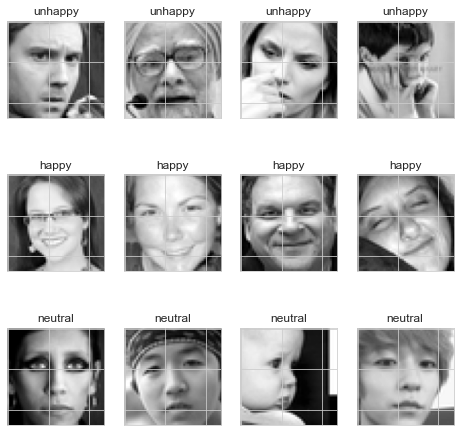

In [104]:
plot_all_emotions(img_num=4)

In [114]:
def plot_per_emotion(emotion=0, img_num=3, init_idx=0):
    fig, axs = plt.subplots(1, img_num, figsize=(16, 16))
    fig.subplots_adjust(hspace = .1, wspace=.1)
    axs = axs.ravel()
              
    pos=0
    idx_arr = y_train_df[y_train_df['emotion']==emotion].index
    for img_idx in range(img_num):
        idx = idx_arr[img_idx+init_idx]
        axs[pos].imshow(X_train[idx][:,:,0], cmap='gray')
        axs[pos].set_title(emotion_cat[emotion])
        axs[pos].set_xticklabels([])
        axs[pos].set_yticklabels([])
        pos+=1

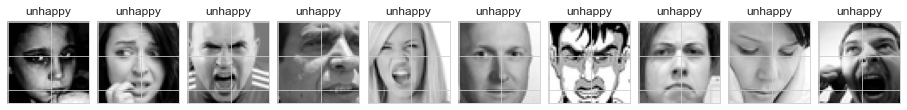

In [116]:
plot_per_emotion(emotion=0, img_num=10, init_idx=10)

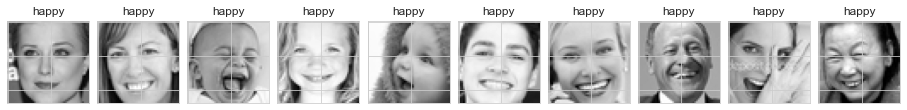

In [118]:
plot_per_emotion(emotion=1, img_num=10, init_idx=10)

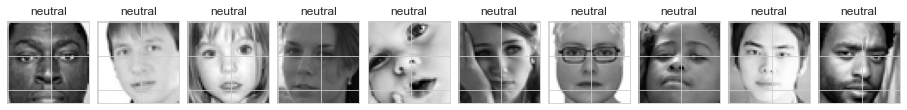

In [119]:
plot_per_emotion(emotion=2, img_num=10, init_idx=10)

In [ ]:
# def image_reshape(data):
#     image = np.reshape(data['images'].to_list(),(data.shape[0],48,48))
#     return image


# #train['pixels'] = train['pixels'].apply(pixels_to_array)
# X_train = image_reshape(train_df)
# y_train = train_df['emotion']


# plt.figure(figsize=[12,12])
# for i in range(36):
#     plt.subplot(6,6,i+1)
#     plt.imshow(X_train[i],cmap="gray")
#     plt.title(emotions[y_train[i]])
#     plt.axis("off")
# plt.show()

## Imbalance Data

* unhappy is 3 times more than neutral and almost double amount of happy data
* using imbalance technique oversampling - smote on training data

In [120]:
import imblearn.over_sampling

smote = imblearn.over_sampling.SMOTE(sampling_strategy='not majority')
X_tr, y_tr = smote.fit_resample(X_train.reshape(-1, img_size*img_size), y_train)


total Test items:40074


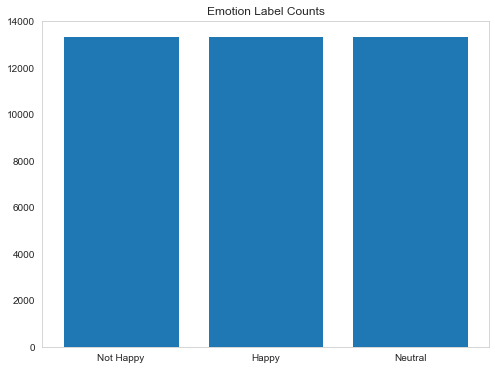

In [121]:
counts_dict = pd.DataFrame(y_tr, columns=['emotion'])['emotion'].value_counts().to_dict()
emotions = ['Not Happy','Happy','Neutral']
print(f"total Test items:{y_tr.shape[0]}")
plot_distribution(counts_dict, emotions)

In [122]:
y_tr_df = pd.DataFrame(y_tr, columns=['emotions'])

In [123]:
idx_unhappy = y_tr_df[y_tr_df['emotions']==0].index
idx_unhappy

Int64Index([    0,     1,     2,     3,     5,     6,     9,    10,    16,
               18,
            ...
            25525, 25526, 25530, 25531, 25532, 25533, 25534, 25535, 25536,
            25537],
           dtype='int64', length=13358)

#### generating images from pixel data for each category / prepared for data augmentation

In [127]:
import os
from keras.preprocessing.image import save_img

for idx, row in y_tr_df.iterrows():
    if row.emotions==0: # not happy
        path = "./input/unhappy/"
        img = '{0}{1}.jpg'.format(path,idx)
        save_img(img, X_tr[idx].reshape(img_size, img_size,1))
    elif row.emotions==1: #happy
        path = "./input/happy/"
        img = '{0}{1}.jpg'.format(path,idx)
        save_img(img, X_tr[idx].reshape(img_size, img_size,1))
    elif row.emotions==2:
        path = "./input/neutral/"
        img = '{0}{1}.jpg'.format(path,idx)
        save_img(img, X_tr[idx].reshape(img_size, img_size,1))
    print(img)


./input/unhappy/0.jpg
./input/unhappy/1.jpg
./input/unhappy/2.jpg
./input/unhappy/3.jpg
./input/neutral/4.jpg
./input/unhappy/5.jpg
./input/unhappy/6.jpg
./input/happy/7.jpg
./input/happy/8.jpg
./input/unhappy/9.jpg
./input/unhappy/10.jpg
./input/neutral/11.jpg
./input/neutral/12.jpg
./input/neutral/13.jpg
./input/happy/14.jpg
./input/happy/15.jpg
./input/unhappy/16.jpg
./input/neutral/17.jpg
./input/unhappy/18.jpg
./input/unhappy/19.jpg
./input/unhappy/20.jpg
./input/unhappy/21.jpg
./input/unhappy/22.jpg
./input/happy/23.jpg
./input/happy/24.jpg
./input/unhappy/25.jpg
./input/happy/26.jpg
./input/happy/27.jpg
./input/neutral/28.jpg
./input/happy/29.jpg
./input/unhappy/30.jpg
./input/happy/31.jpg
./input/neutral/32.jpg
./input/neutral/33.jpg
./input/neutral/34.jpg
./input/unhappy/35.jpg
./input/unhappy/36.jpg
./input/happy/37.jpg
./input/unhappy/38.jpg
./input/unhappy/39.jpg
./input/neutral/40.jpg
./input/unhappy/41.jpg
./input/happy/42.jpg
./input/neutral/43.jpg
./input/unhappy/44.jpg

./input/neutral/369.jpg
./input/unhappy/370.jpg
./input/unhappy/371.jpg
./input/unhappy/372.jpg
./input/unhappy/373.jpg
./input/unhappy/374.jpg
./input/unhappy/375.jpg
./input/unhappy/376.jpg
./input/unhappy/377.jpg
./input/unhappy/378.jpg
./input/unhappy/379.jpg
./input/happy/380.jpg
./input/happy/381.jpg
./input/happy/382.jpg
./input/happy/383.jpg
./input/unhappy/384.jpg
./input/neutral/385.jpg
./input/happy/386.jpg
./input/happy/387.jpg
./input/happy/388.jpg
./input/unhappy/389.jpg
./input/unhappy/390.jpg
./input/neutral/391.jpg
./input/happy/392.jpg
./input/unhappy/393.jpg
./input/unhappy/394.jpg
./input/happy/395.jpg
./input/unhappy/396.jpg
./input/unhappy/397.jpg
./input/happy/398.jpg
./input/unhappy/399.jpg
./input/happy/400.jpg
./input/neutral/401.jpg
./input/unhappy/402.jpg
./input/neutral/403.jpg
./input/unhappy/404.jpg
./input/happy/405.jpg
./input/unhappy/406.jpg
./input/happy/407.jpg
./input/unhappy/408.jpg
./input/neutral/409.jpg
./input/neutral/410.jpg
./input/unhappy/41

./input/neutral/772.jpg
./input/unhappy/773.jpg
./input/happy/774.jpg
./input/unhappy/775.jpg
./input/unhappy/776.jpg
./input/neutral/777.jpg
./input/happy/778.jpg
./input/happy/779.jpg
./input/unhappy/780.jpg
./input/happy/781.jpg
./input/happy/782.jpg
./input/unhappy/783.jpg
./input/unhappy/784.jpg
./input/neutral/785.jpg
./input/unhappy/786.jpg
./input/unhappy/787.jpg
./input/unhappy/788.jpg
./input/neutral/789.jpg
./input/happy/790.jpg
./input/unhappy/791.jpg
./input/unhappy/792.jpg
./input/unhappy/793.jpg
./input/unhappy/794.jpg
./input/neutral/795.jpg
./input/neutral/796.jpg
./input/unhappy/797.jpg
./input/happy/798.jpg
./input/neutral/799.jpg
./input/neutral/800.jpg
./input/unhappy/801.jpg
./input/neutral/802.jpg
./input/unhappy/803.jpg
./input/happy/804.jpg
./input/unhappy/805.jpg
./input/unhappy/806.jpg
./input/unhappy/807.jpg
./input/neutral/808.jpg
./input/happy/809.jpg
./input/unhappy/810.jpg
./input/unhappy/811.jpg
./input/unhappy/812.jpg
./input/neutral/813.jpg
./input/ne

./input/neutral/1137.jpg
./input/neutral/1138.jpg
./input/unhappy/1139.jpg
./input/unhappy/1140.jpg
./input/happy/1141.jpg
./input/neutral/1142.jpg
./input/happy/1143.jpg
./input/unhappy/1144.jpg
./input/unhappy/1145.jpg
./input/neutral/1146.jpg
./input/unhappy/1147.jpg
./input/unhappy/1148.jpg
./input/neutral/1149.jpg
./input/neutral/1150.jpg
./input/unhappy/1151.jpg
./input/neutral/1152.jpg
./input/unhappy/1153.jpg
./input/unhappy/1154.jpg
./input/happy/1155.jpg
./input/unhappy/1156.jpg
./input/unhappy/1157.jpg
./input/unhappy/1158.jpg
./input/neutral/1159.jpg
./input/unhappy/1160.jpg
./input/unhappy/1161.jpg
./input/happy/1162.jpg
./input/unhappy/1163.jpg
./input/happy/1164.jpg
./input/unhappy/1165.jpg
./input/unhappy/1166.jpg
./input/neutral/1167.jpg
./input/neutral/1168.jpg
./input/unhappy/1169.jpg
./input/happy/1170.jpg
./input/neutral/1171.jpg
./input/unhappy/1172.jpg
./input/happy/1173.jpg
./input/unhappy/1174.jpg
./input/unhappy/1175.jpg
./input/neutral/1176.jpg
./input/happy/

./input/unhappy/1534.jpg
./input/unhappy/1535.jpg
./input/unhappy/1536.jpg
./input/unhappy/1537.jpg
./input/unhappy/1538.jpg
./input/unhappy/1539.jpg
./input/happy/1540.jpg
./input/neutral/1541.jpg
./input/unhappy/1542.jpg
./input/unhappy/1543.jpg
./input/neutral/1544.jpg
./input/neutral/1545.jpg
./input/happy/1546.jpg
./input/happy/1547.jpg
./input/unhappy/1548.jpg
./input/unhappy/1549.jpg
./input/unhappy/1550.jpg
./input/neutral/1551.jpg
./input/neutral/1552.jpg
./input/happy/1553.jpg
./input/unhappy/1554.jpg
./input/happy/1555.jpg
./input/unhappy/1556.jpg
./input/unhappy/1557.jpg
./input/neutral/1558.jpg
./input/neutral/1559.jpg
./input/happy/1560.jpg
./input/unhappy/1561.jpg
./input/unhappy/1562.jpg
./input/neutral/1563.jpg
./input/happy/1564.jpg
./input/unhappy/1565.jpg
./input/happy/1566.jpg
./input/happy/1567.jpg
./input/happy/1568.jpg
./input/unhappy/1569.jpg
./input/happy/1570.jpg
./input/unhappy/1571.jpg
./input/happy/1572.jpg
./input/unhappy/1573.jpg
./input/unhappy/1574.jpg

./input/neutral/1887.jpg
./input/unhappy/1888.jpg
./input/unhappy/1889.jpg
./input/unhappy/1890.jpg
./input/unhappy/1891.jpg
./input/neutral/1892.jpg
./input/unhappy/1893.jpg
./input/happy/1894.jpg
./input/happy/1895.jpg
./input/happy/1896.jpg
./input/unhappy/1897.jpg
./input/unhappy/1898.jpg
./input/happy/1899.jpg
./input/unhappy/1900.jpg
./input/unhappy/1901.jpg
./input/unhappy/1902.jpg
./input/neutral/1903.jpg
./input/unhappy/1904.jpg
./input/unhappy/1905.jpg
./input/neutral/1906.jpg
./input/unhappy/1907.jpg
./input/unhappy/1908.jpg
./input/happy/1909.jpg
./input/unhappy/1910.jpg
./input/unhappy/1911.jpg
./input/neutral/1912.jpg
./input/neutral/1913.jpg
./input/unhappy/1914.jpg
./input/neutral/1915.jpg
./input/happy/1916.jpg
./input/unhappy/1917.jpg
./input/unhappy/1918.jpg
./input/unhappy/1919.jpg
./input/unhappy/1920.jpg
./input/unhappy/1921.jpg
./input/unhappy/1922.jpg
./input/happy/1923.jpg
./input/neutral/1924.jpg
./input/happy/1925.jpg
./input/neutral/1926.jpg
./input/neutral/

./input/happy/2278.jpg
./input/unhappy/2279.jpg
./input/happy/2280.jpg
./input/neutral/2281.jpg
./input/happy/2282.jpg
./input/neutral/2283.jpg
./input/unhappy/2284.jpg
./input/unhappy/2285.jpg
./input/unhappy/2286.jpg
./input/unhappy/2287.jpg
./input/unhappy/2288.jpg
./input/unhappy/2289.jpg
./input/unhappy/2290.jpg
./input/unhappy/2291.jpg
./input/unhappy/2292.jpg
./input/neutral/2293.jpg
./input/unhappy/2294.jpg
./input/neutral/2295.jpg
./input/neutral/2296.jpg
./input/unhappy/2297.jpg
./input/neutral/2298.jpg
./input/unhappy/2299.jpg
./input/unhappy/2300.jpg
./input/neutral/2301.jpg
./input/neutral/2302.jpg
./input/neutral/2303.jpg
./input/unhappy/2304.jpg
./input/unhappy/2305.jpg
./input/neutral/2306.jpg
./input/happy/2307.jpg
./input/unhappy/2308.jpg
./input/happy/2309.jpg
./input/unhappy/2310.jpg
./input/unhappy/2311.jpg
./input/unhappy/2312.jpg
./input/unhappy/2313.jpg
./input/happy/2314.jpg
./input/unhappy/2315.jpg
./input/unhappy/2316.jpg
./input/neutral/2317.jpg
./input/neut

./input/unhappy/2682.jpg
./input/happy/2683.jpg
./input/happy/2684.jpg
./input/unhappy/2685.jpg
./input/unhappy/2686.jpg
./input/unhappy/2687.jpg
./input/neutral/2688.jpg
./input/happy/2689.jpg
./input/happy/2690.jpg
./input/neutral/2691.jpg
./input/unhappy/2692.jpg
./input/unhappy/2693.jpg
./input/happy/2694.jpg
./input/unhappy/2695.jpg
./input/happy/2696.jpg
./input/neutral/2697.jpg
./input/unhappy/2698.jpg
./input/unhappy/2699.jpg
./input/happy/2700.jpg
./input/unhappy/2701.jpg
./input/unhappy/2702.jpg
./input/unhappy/2703.jpg
./input/unhappy/2704.jpg
./input/unhappy/2705.jpg
./input/unhappy/2706.jpg
./input/unhappy/2707.jpg
./input/unhappy/2708.jpg
./input/happy/2709.jpg
./input/unhappy/2710.jpg
./input/neutral/2711.jpg
./input/happy/2712.jpg
./input/unhappy/2713.jpg
./input/happy/2714.jpg
./input/happy/2715.jpg
./input/happy/2716.jpg
./input/neutral/2717.jpg
./input/neutral/2718.jpg
./input/neutral/2719.jpg
./input/unhappy/2720.jpg
./input/unhappy/2721.jpg
./input/neutral/2722.jpg

./input/neutral/3031.jpg
./input/neutral/3032.jpg
./input/unhappy/3033.jpg
./input/unhappy/3034.jpg
./input/unhappy/3035.jpg
./input/unhappy/3036.jpg
./input/neutral/3037.jpg
./input/unhappy/3038.jpg
./input/unhappy/3039.jpg
./input/neutral/3040.jpg
./input/happy/3041.jpg
./input/neutral/3042.jpg
./input/happy/3043.jpg
./input/happy/3044.jpg
./input/unhappy/3045.jpg
./input/happy/3046.jpg
./input/happy/3047.jpg
./input/unhappy/3048.jpg
./input/unhappy/3049.jpg
./input/happy/3050.jpg
./input/unhappy/3051.jpg
./input/happy/3052.jpg
./input/happy/3053.jpg
./input/unhappy/3054.jpg
./input/neutral/3055.jpg
./input/unhappy/3056.jpg
./input/happy/3057.jpg
./input/happy/3058.jpg
./input/neutral/3059.jpg
./input/unhappy/3060.jpg
./input/happy/3061.jpg
./input/happy/3062.jpg
./input/unhappy/3063.jpg
./input/unhappy/3064.jpg
./input/unhappy/3065.jpg
./input/happy/3066.jpg
./input/unhappy/3067.jpg
./input/unhappy/3068.jpg
./input/unhappy/3069.jpg
./input/unhappy/3070.jpg
./input/unhappy/3071.jpg
.

./input/happy/3381.jpg
./input/unhappy/3382.jpg
./input/unhappy/3383.jpg
./input/unhappy/3384.jpg
./input/neutral/3385.jpg
./input/unhappy/3386.jpg
./input/unhappy/3387.jpg
./input/happy/3388.jpg
./input/unhappy/3389.jpg
./input/happy/3390.jpg
./input/unhappy/3391.jpg
./input/happy/3392.jpg
./input/unhappy/3393.jpg
./input/neutral/3394.jpg
./input/happy/3395.jpg
./input/neutral/3396.jpg
./input/unhappy/3397.jpg
./input/unhappy/3398.jpg
./input/neutral/3399.jpg
./input/unhappy/3400.jpg
./input/happy/3401.jpg
./input/neutral/3402.jpg
./input/happy/3403.jpg
./input/unhappy/3404.jpg
./input/unhappy/3405.jpg
./input/neutral/3406.jpg
./input/unhappy/3407.jpg
./input/neutral/3408.jpg
./input/neutral/3409.jpg
./input/unhappy/3410.jpg
./input/unhappy/3411.jpg
./input/neutral/3412.jpg
./input/unhappy/3413.jpg
./input/happy/3414.jpg
./input/unhappy/3415.jpg
./input/happy/3416.jpg
./input/unhappy/3417.jpg
./input/unhappy/3418.jpg
./input/neutral/3419.jpg
./input/unhappy/3420.jpg
./input/happy/3421

./input/unhappy/3727.jpg
./input/happy/3728.jpg
./input/neutral/3729.jpg
./input/neutral/3730.jpg
./input/neutral/3731.jpg
./input/happy/3732.jpg
./input/unhappy/3733.jpg
./input/happy/3734.jpg
./input/neutral/3735.jpg
./input/unhappy/3736.jpg
./input/unhappy/3737.jpg
./input/happy/3738.jpg
./input/unhappy/3739.jpg
./input/happy/3740.jpg
./input/happy/3741.jpg
./input/unhappy/3742.jpg
./input/happy/3743.jpg
./input/happy/3744.jpg
./input/happy/3745.jpg
./input/unhappy/3746.jpg
./input/neutral/3747.jpg
./input/happy/3748.jpg
./input/unhappy/3749.jpg
./input/happy/3750.jpg
./input/happy/3751.jpg
./input/unhappy/3752.jpg
./input/neutral/3753.jpg
./input/happy/3754.jpg
./input/happy/3755.jpg
./input/neutral/3756.jpg
./input/unhappy/3757.jpg
./input/unhappy/3758.jpg
./input/neutral/3759.jpg
./input/happy/3760.jpg
./input/unhappy/3761.jpg
./input/unhappy/3762.jpg
./input/neutral/3763.jpg
./input/neutral/3764.jpg
./input/unhappy/3765.jpg
./input/unhappy/3766.jpg
./input/unhappy/3767.jpg
./inp

./input/unhappy/4065.jpg
./input/happy/4066.jpg
./input/unhappy/4067.jpg
./input/unhappy/4068.jpg
./input/unhappy/4069.jpg
./input/unhappy/4070.jpg
./input/unhappy/4071.jpg
./input/unhappy/4072.jpg
./input/happy/4073.jpg
./input/happy/4074.jpg
./input/unhappy/4075.jpg
./input/unhappy/4076.jpg
./input/happy/4077.jpg
./input/neutral/4078.jpg
./input/neutral/4079.jpg
./input/neutral/4080.jpg
./input/neutral/4081.jpg
./input/unhappy/4082.jpg
./input/unhappy/4083.jpg
./input/happy/4084.jpg
./input/happy/4085.jpg
./input/happy/4086.jpg
./input/happy/4087.jpg
./input/neutral/4088.jpg
./input/happy/4089.jpg
./input/neutral/4090.jpg
./input/happy/4091.jpg
./input/happy/4092.jpg
./input/happy/4093.jpg
./input/happy/4094.jpg
./input/unhappy/4095.jpg
./input/neutral/4096.jpg
./input/neutral/4097.jpg
./input/unhappy/4098.jpg
./input/happy/4099.jpg
./input/unhappy/4100.jpg
./input/unhappy/4101.jpg
./input/happy/4102.jpg
./input/unhappy/4103.jpg
./input/neutral/4104.jpg
./input/unhappy/4105.jpg
./inp

./input/happy/4481.jpg
./input/happy/4482.jpg
./input/unhappy/4483.jpg
./input/unhappy/4484.jpg
./input/happy/4485.jpg
./input/unhappy/4486.jpg
./input/neutral/4487.jpg
./input/unhappy/4488.jpg
./input/neutral/4489.jpg
./input/unhappy/4490.jpg
./input/neutral/4491.jpg
./input/neutral/4492.jpg
./input/neutral/4493.jpg
./input/unhappy/4494.jpg
./input/unhappy/4495.jpg
./input/unhappy/4496.jpg
./input/unhappy/4497.jpg
./input/unhappy/4498.jpg
./input/unhappy/4499.jpg
./input/happy/4500.jpg
./input/happy/4501.jpg
./input/unhappy/4502.jpg
./input/unhappy/4503.jpg
./input/neutral/4504.jpg
./input/unhappy/4505.jpg
./input/unhappy/4506.jpg
./input/unhappy/4507.jpg
./input/happy/4508.jpg
./input/happy/4509.jpg
./input/neutral/4510.jpg
./input/unhappy/4511.jpg
./input/neutral/4512.jpg
./input/happy/4513.jpg
./input/happy/4514.jpg
./input/neutral/4515.jpg
./input/happy/4516.jpg
./input/neutral/4517.jpg
./input/unhappy/4518.jpg
./input/neutral/4519.jpg
./input/happy/4520.jpg
./input/unhappy/4521.j

./input/unhappy/4871.jpg
./input/unhappy/4872.jpg
./input/happy/4873.jpg
./input/unhappy/4874.jpg
./input/unhappy/4875.jpg
./input/neutral/4876.jpg
./input/happy/4877.jpg
./input/unhappy/4878.jpg
./input/happy/4879.jpg
./input/unhappy/4880.jpg
./input/unhappy/4881.jpg
./input/neutral/4882.jpg
./input/happy/4883.jpg
./input/neutral/4884.jpg
./input/neutral/4885.jpg
./input/neutral/4886.jpg
./input/happy/4887.jpg
./input/happy/4888.jpg
./input/happy/4889.jpg
./input/neutral/4890.jpg
./input/happy/4891.jpg
./input/neutral/4892.jpg
./input/happy/4893.jpg
./input/unhappy/4894.jpg
./input/unhappy/4895.jpg
./input/happy/4896.jpg
./input/happy/4897.jpg
./input/neutral/4898.jpg
./input/unhappy/4899.jpg
./input/happy/4900.jpg
./input/happy/4901.jpg
./input/happy/4902.jpg
./input/neutral/4903.jpg
./input/neutral/4904.jpg
./input/unhappy/4905.jpg
./input/unhappy/4906.jpg
./input/neutral/4907.jpg
./input/unhappy/4908.jpg
./input/unhappy/4909.jpg
./input/happy/4910.jpg
./input/neutral/4911.jpg
./inp

./input/unhappy/5266.jpg
./input/neutral/5267.jpg
./input/happy/5268.jpg
./input/neutral/5269.jpg
./input/unhappy/5270.jpg
./input/unhappy/5271.jpg
./input/neutral/5272.jpg
./input/neutral/5273.jpg
./input/neutral/5274.jpg
./input/neutral/5275.jpg
./input/unhappy/5276.jpg
./input/unhappy/5277.jpg
./input/neutral/5278.jpg
./input/happy/5279.jpg
./input/unhappy/5280.jpg
./input/unhappy/5281.jpg
./input/neutral/5282.jpg
./input/unhappy/5283.jpg
./input/neutral/5284.jpg
./input/happy/5285.jpg
./input/unhappy/5286.jpg
./input/unhappy/5287.jpg
./input/unhappy/5288.jpg
./input/unhappy/5289.jpg
./input/unhappy/5290.jpg
./input/happy/5291.jpg
./input/neutral/5292.jpg
./input/unhappy/5293.jpg
./input/unhappy/5294.jpg
./input/happy/5295.jpg
./input/unhappy/5296.jpg
./input/unhappy/5297.jpg
./input/neutral/5298.jpg
./input/happy/5299.jpg
./input/unhappy/5300.jpg
./input/neutral/5301.jpg
./input/happy/5302.jpg
./input/unhappy/5303.jpg
./input/happy/5304.jpg
./input/neutral/5305.jpg
./input/happy/53

./input/unhappy/5614.jpg
./input/neutral/5615.jpg
./input/unhappy/5616.jpg
./input/happy/5617.jpg
./input/happy/5618.jpg
./input/happy/5619.jpg
./input/unhappy/5620.jpg
./input/unhappy/5621.jpg
./input/happy/5622.jpg
./input/happy/5623.jpg
./input/unhappy/5624.jpg
./input/happy/5625.jpg
./input/neutral/5626.jpg
./input/happy/5627.jpg
./input/unhappy/5628.jpg
./input/happy/5629.jpg
./input/unhappy/5630.jpg
./input/unhappy/5631.jpg
./input/happy/5632.jpg
./input/neutral/5633.jpg
./input/neutral/5634.jpg
./input/unhappy/5635.jpg
./input/unhappy/5636.jpg
./input/happy/5637.jpg
./input/unhappy/5638.jpg
./input/happy/5639.jpg
./input/happy/5640.jpg
./input/unhappy/5641.jpg
./input/happy/5642.jpg
./input/unhappy/5643.jpg
./input/happy/5644.jpg
./input/happy/5645.jpg
./input/unhappy/5646.jpg
./input/unhappy/5647.jpg
./input/happy/5648.jpg
./input/unhappy/5649.jpg
./input/neutral/5650.jpg
./input/unhappy/5651.jpg
./input/unhappy/5652.jpg
./input/unhappy/5653.jpg
./input/happy/5654.jpg
./input/u

./input/happy/5998.jpg
./input/happy/5999.jpg
./input/neutral/6000.jpg
./input/unhappy/6001.jpg
./input/unhappy/6002.jpg
./input/unhappy/6003.jpg
./input/happy/6004.jpg
./input/unhappy/6005.jpg
./input/happy/6006.jpg
./input/unhappy/6007.jpg
./input/neutral/6008.jpg
./input/unhappy/6009.jpg
./input/unhappy/6010.jpg
./input/unhappy/6011.jpg
./input/unhappy/6012.jpg
./input/unhappy/6013.jpg
./input/unhappy/6014.jpg
./input/unhappy/6015.jpg
./input/unhappy/6016.jpg
./input/unhappy/6017.jpg
./input/unhappy/6018.jpg
./input/unhappy/6019.jpg
./input/unhappy/6020.jpg
./input/happy/6021.jpg
./input/neutral/6022.jpg
./input/neutral/6023.jpg
./input/happy/6024.jpg
./input/unhappy/6025.jpg
./input/unhappy/6026.jpg
./input/unhappy/6027.jpg
./input/unhappy/6028.jpg
./input/unhappy/6029.jpg
./input/unhappy/6030.jpg
./input/unhappy/6031.jpg
./input/unhappy/6032.jpg
./input/happy/6033.jpg
./input/neutral/6034.jpg
./input/happy/6035.jpg
./input/unhappy/6036.jpg
./input/unhappy/6037.jpg
./input/unhappy/

./input/unhappy/6374.jpg
./input/happy/6375.jpg
./input/unhappy/6376.jpg
./input/neutral/6377.jpg
./input/happy/6378.jpg
./input/unhappy/6379.jpg
./input/happy/6380.jpg
./input/unhappy/6381.jpg
./input/unhappy/6382.jpg
./input/unhappy/6383.jpg
./input/neutral/6384.jpg
./input/unhappy/6385.jpg
./input/happy/6386.jpg
./input/happy/6387.jpg
./input/neutral/6388.jpg
./input/unhappy/6389.jpg
./input/unhappy/6390.jpg
./input/happy/6391.jpg
./input/happy/6392.jpg
./input/neutral/6393.jpg
./input/neutral/6394.jpg
./input/unhappy/6395.jpg
./input/unhappy/6396.jpg
./input/happy/6397.jpg
./input/unhappy/6398.jpg
./input/happy/6399.jpg
./input/happy/6400.jpg
./input/unhappy/6401.jpg
./input/unhappy/6402.jpg
./input/happy/6403.jpg
./input/unhappy/6404.jpg
./input/unhappy/6405.jpg
./input/neutral/6406.jpg
./input/happy/6407.jpg
./input/happy/6408.jpg
./input/happy/6409.jpg
./input/unhappy/6410.jpg
./input/unhappy/6411.jpg
./input/happy/6412.jpg
./input/unhappy/6413.jpg
./input/unhappy/6414.jpg
./inp

./input/unhappy/6774.jpg
./input/neutral/6775.jpg
./input/unhappy/6776.jpg
./input/happy/6777.jpg
./input/unhappy/6778.jpg
./input/unhappy/6779.jpg
./input/unhappy/6780.jpg
./input/unhappy/6781.jpg
./input/happy/6782.jpg
./input/unhappy/6783.jpg
./input/happy/6784.jpg
./input/unhappy/6785.jpg
./input/unhappy/6786.jpg
./input/neutral/6787.jpg
./input/unhappy/6788.jpg
./input/happy/6789.jpg
./input/unhappy/6790.jpg
./input/unhappy/6791.jpg
./input/unhappy/6792.jpg
./input/unhappy/6793.jpg
./input/happy/6794.jpg
./input/unhappy/6795.jpg
./input/happy/6796.jpg
./input/neutral/6797.jpg
./input/unhappy/6798.jpg
./input/unhappy/6799.jpg
./input/happy/6800.jpg
./input/happy/6801.jpg
./input/unhappy/6802.jpg
./input/neutral/6803.jpg
./input/neutral/6804.jpg
./input/neutral/6805.jpg
./input/happy/6806.jpg
./input/neutral/6807.jpg
./input/unhappy/6808.jpg
./input/happy/6809.jpg
./input/unhappy/6810.jpg
./input/happy/6811.jpg
./input/happy/6812.jpg
./input/unhappy/6813.jpg
./input/unhappy/6814.jpg

./input/neutral/7163.jpg
./input/unhappy/7164.jpg
./input/unhappy/7165.jpg
./input/neutral/7166.jpg
./input/happy/7167.jpg
./input/unhappy/7168.jpg
./input/unhappy/7169.jpg
./input/unhappy/7170.jpg
./input/unhappy/7171.jpg
./input/happy/7172.jpg
./input/neutral/7173.jpg
./input/happy/7174.jpg
./input/happy/7175.jpg
./input/neutral/7176.jpg
./input/unhappy/7177.jpg
./input/unhappy/7178.jpg
./input/unhappy/7179.jpg
./input/happy/7180.jpg
./input/unhappy/7181.jpg
./input/happy/7182.jpg
./input/happy/7183.jpg
./input/unhappy/7184.jpg
./input/happy/7185.jpg
./input/happy/7186.jpg
./input/happy/7187.jpg
./input/unhappy/7188.jpg
./input/happy/7189.jpg
./input/unhappy/7190.jpg
./input/unhappy/7191.jpg
./input/unhappy/7192.jpg
./input/unhappy/7193.jpg
./input/happy/7194.jpg
./input/unhappy/7195.jpg
./input/unhappy/7196.jpg
./input/unhappy/7197.jpg
./input/unhappy/7198.jpg
./input/unhappy/7199.jpg
./input/neutral/7200.jpg
./input/happy/7201.jpg
./input/happy/7202.jpg
./input/unhappy/7203.jpg
./i

./input/happy/7539.jpg
./input/happy/7540.jpg
./input/neutral/7541.jpg
./input/neutral/7542.jpg
./input/unhappy/7543.jpg
./input/unhappy/7544.jpg
./input/unhappy/7545.jpg
./input/happy/7546.jpg
./input/unhappy/7547.jpg
./input/happy/7548.jpg
./input/unhappy/7549.jpg
./input/happy/7550.jpg
./input/unhappy/7551.jpg
./input/unhappy/7552.jpg
./input/unhappy/7553.jpg
./input/unhappy/7554.jpg
./input/happy/7555.jpg
./input/unhappy/7556.jpg
./input/happy/7557.jpg
./input/neutral/7558.jpg
./input/unhappy/7559.jpg
./input/happy/7560.jpg
./input/unhappy/7561.jpg
./input/unhappy/7562.jpg
./input/happy/7563.jpg
./input/unhappy/7564.jpg
./input/happy/7565.jpg
./input/happy/7566.jpg
./input/unhappy/7567.jpg
./input/unhappy/7568.jpg
./input/neutral/7569.jpg
./input/happy/7570.jpg
./input/happy/7571.jpg
./input/unhappy/7572.jpg
./input/happy/7573.jpg
./input/happy/7574.jpg
./input/neutral/7575.jpg
./input/unhappy/7576.jpg
./input/happy/7577.jpg
./input/unhappy/7578.jpg
./input/happy/7579.jpg
./input/n

./input/unhappy/7918.jpg
./input/unhappy/7919.jpg
./input/unhappy/7920.jpg
./input/unhappy/7921.jpg
./input/neutral/7922.jpg
./input/unhappy/7923.jpg
./input/neutral/7924.jpg
./input/neutral/7925.jpg
./input/neutral/7926.jpg
./input/unhappy/7927.jpg
./input/happy/7928.jpg
./input/unhappy/7929.jpg
./input/happy/7930.jpg
./input/happy/7931.jpg
./input/unhappy/7932.jpg
./input/neutral/7933.jpg
./input/unhappy/7934.jpg
./input/unhappy/7935.jpg
./input/neutral/7936.jpg
./input/unhappy/7937.jpg
./input/unhappy/7938.jpg
./input/neutral/7939.jpg
./input/unhappy/7940.jpg
./input/unhappy/7941.jpg
./input/unhappy/7942.jpg
./input/happy/7943.jpg
./input/happy/7944.jpg
./input/neutral/7945.jpg
./input/neutral/7946.jpg
./input/happy/7947.jpg
./input/unhappy/7948.jpg
./input/neutral/7949.jpg
./input/unhappy/7950.jpg
./input/neutral/7951.jpg
./input/happy/7952.jpg
./input/happy/7953.jpg
./input/happy/7954.jpg
./input/unhappy/7955.jpg
./input/unhappy/7956.jpg
./input/neutral/7957.jpg
./input/unhappy/79

./input/neutral/8292.jpg
./input/unhappy/8293.jpg
./input/happy/8294.jpg
./input/neutral/8295.jpg
./input/happy/8296.jpg
./input/unhappy/8297.jpg
./input/happy/8298.jpg
./input/unhappy/8299.jpg
./input/happy/8300.jpg
./input/happy/8301.jpg
./input/unhappy/8302.jpg
./input/neutral/8303.jpg
./input/neutral/8304.jpg
./input/neutral/8305.jpg
./input/unhappy/8306.jpg
./input/unhappy/8307.jpg
./input/happy/8308.jpg
./input/happy/8309.jpg
./input/happy/8310.jpg
./input/unhappy/8311.jpg
./input/neutral/8312.jpg
./input/happy/8313.jpg
./input/unhappy/8314.jpg
./input/unhappy/8315.jpg
./input/happy/8316.jpg
./input/happy/8317.jpg
./input/happy/8318.jpg
./input/happy/8319.jpg
./input/unhappy/8320.jpg
./input/neutral/8321.jpg
./input/unhappy/8322.jpg
./input/happy/8323.jpg
./input/unhappy/8324.jpg
./input/happy/8325.jpg
./input/unhappy/8326.jpg
./input/happy/8327.jpg
./input/unhappy/8328.jpg
./input/happy/8329.jpg
./input/unhappy/8330.jpg
./input/neutral/8331.jpg
./input/unhappy/8332.jpg
./input/u

./input/unhappy/8668.jpg
./input/neutral/8669.jpg
./input/neutral/8670.jpg
./input/unhappy/8671.jpg
./input/unhappy/8672.jpg
./input/unhappy/8673.jpg
./input/neutral/8674.jpg
./input/neutral/8675.jpg
./input/neutral/8676.jpg
./input/unhappy/8677.jpg
./input/unhappy/8678.jpg
./input/unhappy/8679.jpg
./input/unhappy/8680.jpg
./input/unhappy/8681.jpg
./input/unhappy/8682.jpg
./input/unhappy/8683.jpg
./input/unhappy/8684.jpg
./input/unhappy/8685.jpg
./input/unhappy/8686.jpg
./input/neutral/8687.jpg
./input/unhappy/8688.jpg
./input/unhappy/8689.jpg
./input/unhappy/8690.jpg
./input/happy/8691.jpg
./input/unhappy/8692.jpg
./input/unhappy/8693.jpg
./input/happy/8694.jpg
./input/unhappy/8695.jpg
./input/unhappy/8696.jpg
./input/unhappy/8697.jpg
./input/unhappy/8698.jpg
./input/unhappy/8699.jpg
./input/unhappy/8700.jpg
./input/unhappy/8701.jpg
./input/unhappy/8702.jpg
./input/neutral/8703.jpg
./input/unhappy/8704.jpg
./input/unhappy/8705.jpg
./input/neutral/8706.jpg
./input/unhappy/8707.jpg
./in

./input/neutral/9032.jpg
./input/happy/9033.jpg
./input/neutral/9034.jpg
./input/unhappy/9035.jpg
./input/happy/9036.jpg
./input/happy/9037.jpg
./input/happy/9038.jpg
./input/happy/9039.jpg
./input/unhappy/9040.jpg
./input/neutral/9041.jpg
./input/happy/9042.jpg
./input/happy/9043.jpg
./input/unhappy/9044.jpg
./input/unhappy/9045.jpg
./input/unhappy/9046.jpg
./input/neutral/9047.jpg
./input/happy/9048.jpg
./input/unhappy/9049.jpg
./input/happy/9050.jpg
./input/unhappy/9051.jpg
./input/unhappy/9052.jpg
./input/happy/9053.jpg
./input/happy/9054.jpg
./input/unhappy/9055.jpg
./input/happy/9056.jpg
./input/happy/9057.jpg
./input/happy/9058.jpg
./input/unhappy/9059.jpg
./input/unhappy/9060.jpg
./input/unhappy/9061.jpg
./input/happy/9062.jpg
./input/unhappy/9063.jpg
./input/happy/9064.jpg
./input/unhappy/9065.jpg
./input/unhappy/9066.jpg
./input/unhappy/9067.jpg
./input/unhappy/9068.jpg
./input/neutral/9069.jpg
./input/neutral/9070.jpg
./input/neutral/9071.jpg
./input/unhappy/9072.jpg
./input

./input/unhappy/9400.jpg
./input/unhappy/9401.jpg
./input/unhappy/9402.jpg
./input/unhappy/9403.jpg
./input/neutral/9404.jpg
./input/happy/9405.jpg
./input/unhappy/9406.jpg
./input/happy/9407.jpg
./input/unhappy/9408.jpg
./input/unhappy/9409.jpg
./input/happy/9410.jpg
./input/unhappy/9411.jpg
./input/unhappy/9412.jpg
./input/unhappy/9413.jpg
./input/unhappy/9414.jpg
./input/unhappy/9415.jpg
./input/neutral/9416.jpg
./input/unhappy/9417.jpg
./input/unhappy/9418.jpg
./input/unhappy/9419.jpg
./input/neutral/9420.jpg
./input/unhappy/9421.jpg
./input/neutral/9422.jpg
./input/happy/9423.jpg
./input/happy/9424.jpg
./input/unhappy/9425.jpg
./input/unhappy/9426.jpg
./input/happy/9427.jpg
./input/unhappy/9428.jpg
./input/happy/9429.jpg
./input/unhappy/9430.jpg
./input/unhappy/9431.jpg
./input/unhappy/9432.jpg
./input/neutral/9433.jpg
./input/neutral/9434.jpg
./input/happy/9435.jpg
./input/unhappy/9436.jpg
./input/unhappy/9437.jpg
./input/happy/9438.jpg
./input/unhappy/9439.jpg
./input/unhappy/94

./input/unhappy/9762.jpg
./input/unhappy/9763.jpg
./input/unhappy/9764.jpg
./input/neutral/9765.jpg
./input/unhappy/9766.jpg
./input/happy/9767.jpg
./input/unhappy/9768.jpg
./input/happy/9769.jpg
./input/unhappy/9770.jpg
./input/unhappy/9771.jpg
./input/unhappy/9772.jpg
./input/unhappy/9773.jpg
./input/neutral/9774.jpg
./input/unhappy/9775.jpg
./input/neutral/9776.jpg
./input/happy/9777.jpg
./input/unhappy/9778.jpg
./input/happy/9779.jpg
./input/unhappy/9780.jpg
./input/unhappy/9781.jpg
./input/unhappy/9782.jpg
./input/unhappy/9783.jpg
./input/unhappy/9784.jpg
./input/unhappy/9785.jpg
./input/unhappy/9786.jpg
./input/unhappy/9787.jpg
./input/unhappy/9788.jpg
./input/unhappy/9789.jpg
./input/unhappy/9790.jpg
./input/unhappy/9791.jpg
./input/unhappy/9792.jpg
./input/unhappy/9793.jpg
./input/happy/9794.jpg
./input/happy/9795.jpg
./input/unhappy/9796.jpg
./input/unhappy/9797.jpg
./input/unhappy/9798.jpg
./input/happy/9799.jpg
./input/happy/9800.jpg
./input/neutral/9801.jpg
./input/unhappy/

./input/happy/10120.jpg
./input/happy/10121.jpg
./input/happy/10122.jpg
./input/unhappy/10123.jpg
./input/unhappy/10124.jpg
./input/neutral/10125.jpg
./input/unhappy/10126.jpg
./input/happy/10127.jpg
./input/unhappy/10128.jpg
./input/neutral/10129.jpg
./input/unhappy/10130.jpg
./input/unhappy/10131.jpg
./input/unhappy/10132.jpg
./input/unhappy/10133.jpg
./input/unhappy/10134.jpg
./input/unhappy/10135.jpg
./input/unhappy/10136.jpg
./input/neutral/10137.jpg
./input/unhappy/10138.jpg
./input/unhappy/10139.jpg
./input/unhappy/10140.jpg
./input/unhappy/10141.jpg
./input/happy/10142.jpg
./input/neutral/10143.jpg
./input/unhappy/10144.jpg
./input/neutral/10145.jpg
./input/unhappy/10146.jpg
./input/unhappy/10147.jpg
./input/unhappy/10148.jpg
./input/happy/10149.jpg
./input/unhappy/10150.jpg
./input/happy/10151.jpg
./input/unhappy/10152.jpg
./input/unhappy/10153.jpg
./input/neutral/10154.jpg
./input/unhappy/10155.jpg
./input/unhappy/10156.jpg
./input/neutral/10157.jpg
./input/unhappy/10158.jpg


./input/neutral/10498.jpg
./input/happy/10499.jpg
./input/unhappy/10500.jpg
./input/unhappy/10501.jpg
./input/happy/10502.jpg
./input/happy/10503.jpg
./input/unhappy/10504.jpg
./input/unhappy/10505.jpg
./input/neutral/10506.jpg
./input/neutral/10507.jpg
./input/unhappy/10508.jpg
./input/unhappy/10509.jpg
./input/neutral/10510.jpg
./input/neutral/10511.jpg
./input/happy/10512.jpg
./input/unhappy/10513.jpg
./input/neutral/10514.jpg
./input/neutral/10515.jpg
./input/unhappy/10516.jpg
./input/happy/10517.jpg
./input/unhappy/10518.jpg
./input/happy/10519.jpg
./input/unhappy/10520.jpg
./input/happy/10521.jpg
./input/neutral/10522.jpg
./input/happy/10523.jpg
./input/neutral/10524.jpg
./input/happy/10525.jpg
./input/unhappy/10526.jpg
./input/happy/10527.jpg
./input/happy/10528.jpg
./input/unhappy/10529.jpg
./input/unhappy/10530.jpg
./input/unhappy/10531.jpg
./input/happy/10532.jpg
./input/happy/10533.jpg
./input/happy/10534.jpg
./input/neutral/10535.jpg
./input/unhappy/10536.jpg
./input/happy/

./input/unhappy/10884.jpg
./input/unhappy/10885.jpg
./input/unhappy/10886.jpg
./input/neutral/10887.jpg
./input/unhappy/10888.jpg
./input/neutral/10889.jpg
./input/unhappy/10890.jpg
./input/unhappy/10891.jpg
./input/unhappy/10892.jpg
./input/unhappy/10893.jpg
./input/happy/10894.jpg
./input/unhappy/10895.jpg
./input/happy/10896.jpg
./input/unhappy/10897.jpg
./input/unhappy/10898.jpg
./input/unhappy/10899.jpg
./input/unhappy/10900.jpg
./input/neutral/10901.jpg
./input/neutral/10902.jpg
./input/happy/10903.jpg
./input/unhappy/10904.jpg
./input/unhappy/10905.jpg
./input/unhappy/10906.jpg
./input/happy/10907.jpg
./input/unhappy/10908.jpg
./input/unhappy/10909.jpg
./input/neutral/10910.jpg
./input/neutral/10911.jpg
./input/unhappy/10912.jpg
./input/neutral/10913.jpg
./input/unhappy/10914.jpg
./input/unhappy/10915.jpg
./input/happy/10916.jpg
./input/neutral/10917.jpg
./input/unhappy/10918.jpg
./input/unhappy/10919.jpg
./input/unhappy/10920.jpg
./input/unhappy/10921.jpg
./input/unhappy/10922.

./input/happy/11256.jpg
./input/unhappy/11257.jpg
./input/unhappy/11258.jpg
./input/unhappy/11259.jpg
./input/happy/11260.jpg
./input/happy/11261.jpg
./input/happy/11262.jpg
./input/neutral/11263.jpg
./input/unhappy/11264.jpg
./input/happy/11265.jpg
./input/neutral/11266.jpg
./input/unhappy/11267.jpg
./input/unhappy/11268.jpg
./input/unhappy/11269.jpg
./input/happy/11270.jpg
./input/neutral/11271.jpg
./input/happy/11272.jpg
./input/neutral/11273.jpg
./input/unhappy/11274.jpg
./input/neutral/11275.jpg
./input/unhappy/11276.jpg
./input/unhappy/11277.jpg
./input/unhappy/11278.jpg
./input/neutral/11279.jpg
./input/neutral/11280.jpg
./input/unhappy/11281.jpg
./input/neutral/11282.jpg
./input/neutral/11283.jpg
./input/neutral/11284.jpg
./input/neutral/11285.jpg
./input/happy/11286.jpg
./input/unhappy/11287.jpg
./input/neutral/11288.jpg
./input/neutral/11289.jpg
./input/unhappy/11290.jpg
./input/unhappy/11291.jpg
./input/unhappy/11292.jpg
./input/unhappy/11293.jpg
./input/unhappy/11294.jpg
./

./input/neutral/11629.jpg
./input/neutral/11630.jpg
./input/unhappy/11631.jpg
./input/happy/11632.jpg
./input/neutral/11633.jpg
./input/unhappy/11634.jpg
./input/unhappy/11635.jpg
./input/happy/11636.jpg
./input/happy/11637.jpg
./input/unhappy/11638.jpg
./input/happy/11639.jpg
./input/unhappy/11640.jpg
./input/unhappy/11641.jpg
./input/unhappy/11642.jpg
./input/happy/11643.jpg
./input/happy/11644.jpg
./input/happy/11645.jpg
./input/unhappy/11646.jpg
./input/unhappy/11647.jpg
./input/unhappy/11648.jpg
./input/unhappy/11649.jpg
./input/unhappy/11650.jpg
./input/happy/11651.jpg
./input/unhappy/11652.jpg
./input/happy/11653.jpg
./input/happy/11654.jpg
./input/happy/11655.jpg
./input/unhappy/11656.jpg
./input/happy/11657.jpg
./input/unhappy/11658.jpg
./input/neutral/11659.jpg
./input/neutral/11660.jpg
./input/unhappy/11661.jpg
./input/neutral/11662.jpg
./input/unhappy/11663.jpg
./input/unhappy/11664.jpg
./input/happy/11665.jpg
./input/happy/11666.jpg
./input/neutral/11667.jpg
./input/happy/

./input/unhappy/11982.jpg
./input/unhappy/11983.jpg
./input/unhappy/11984.jpg
./input/neutral/11985.jpg
./input/neutral/11986.jpg
./input/unhappy/11987.jpg
./input/happy/11988.jpg
./input/unhappy/11989.jpg
./input/unhappy/11990.jpg
./input/unhappy/11991.jpg
./input/unhappy/11992.jpg
./input/happy/11993.jpg
./input/neutral/11994.jpg
./input/unhappy/11995.jpg
./input/unhappy/11996.jpg
./input/unhappy/11997.jpg
./input/happy/11998.jpg
./input/unhappy/11999.jpg
./input/happy/12000.jpg
./input/unhappy/12001.jpg
./input/unhappy/12002.jpg
./input/happy/12003.jpg
./input/happy/12004.jpg
./input/neutral/12005.jpg
./input/unhappy/12006.jpg
./input/neutral/12007.jpg
./input/neutral/12008.jpg
./input/unhappy/12009.jpg
./input/neutral/12010.jpg
./input/happy/12011.jpg
./input/happy/12012.jpg
./input/unhappy/12013.jpg
./input/unhappy/12014.jpg
./input/happy/12015.jpg
./input/unhappy/12016.jpg
./input/happy/12017.jpg
./input/happy/12018.jpg
./input/unhappy/12019.jpg
./input/unhappy/12020.jpg
./input/

./input/happy/12324.jpg
./input/happy/12325.jpg
./input/happy/12326.jpg
./input/neutral/12327.jpg
./input/unhappy/12328.jpg
./input/happy/12329.jpg
./input/neutral/12330.jpg
./input/neutral/12331.jpg
./input/unhappy/12332.jpg
./input/happy/12333.jpg
./input/neutral/12334.jpg
./input/neutral/12335.jpg
./input/unhappy/12336.jpg
./input/neutral/12337.jpg
./input/happy/12338.jpg
./input/happy/12339.jpg
./input/unhappy/12340.jpg
./input/happy/12341.jpg
./input/happy/12342.jpg
./input/neutral/12343.jpg
./input/unhappy/12344.jpg
./input/unhappy/12345.jpg
./input/neutral/12346.jpg
./input/unhappy/12347.jpg
./input/neutral/12348.jpg
./input/happy/12349.jpg
./input/happy/12350.jpg
./input/neutral/12351.jpg
./input/unhappy/12352.jpg
./input/happy/12353.jpg
./input/unhappy/12354.jpg
./input/unhappy/12355.jpg
./input/happy/12356.jpg
./input/neutral/12357.jpg
./input/unhappy/12358.jpg
./input/unhappy/12359.jpg
./input/unhappy/12360.jpg
./input/unhappy/12361.jpg
./input/unhappy/12362.jpg
./input/unha

./input/unhappy/12681.jpg
./input/unhappy/12682.jpg
./input/unhappy/12683.jpg
./input/unhappy/12684.jpg
./input/happy/12685.jpg
./input/unhappy/12686.jpg
./input/unhappy/12687.jpg
./input/unhappy/12688.jpg
./input/neutral/12689.jpg
./input/unhappy/12690.jpg
./input/unhappy/12691.jpg
./input/unhappy/12692.jpg
./input/unhappy/12693.jpg
./input/unhappy/12694.jpg
./input/unhappy/12695.jpg
./input/neutral/12696.jpg
./input/unhappy/12697.jpg
./input/happy/12698.jpg
./input/unhappy/12699.jpg
./input/unhappy/12700.jpg
./input/happy/12701.jpg
./input/neutral/12702.jpg
./input/unhappy/12703.jpg
./input/unhappy/12704.jpg
./input/happy/12705.jpg
./input/neutral/12706.jpg
./input/unhappy/12707.jpg
./input/unhappy/12708.jpg
./input/unhappy/12709.jpg
./input/happy/12710.jpg
./input/unhappy/12711.jpg
./input/happy/12712.jpg
./input/neutral/12713.jpg
./input/happy/12714.jpg
./input/unhappy/12715.jpg
./input/happy/12716.jpg
./input/unhappy/12717.jpg
./input/happy/12718.jpg
./input/unhappy/12719.jpg
./in

./input/happy/13072.jpg
./input/unhappy/13073.jpg
./input/unhappy/13074.jpg
./input/unhappy/13075.jpg
./input/happy/13076.jpg
./input/unhappy/13077.jpg
./input/unhappy/13078.jpg
./input/happy/13079.jpg
./input/unhappy/13080.jpg
./input/unhappy/13081.jpg
./input/neutral/13082.jpg
./input/unhappy/13083.jpg
./input/neutral/13084.jpg
./input/neutral/13085.jpg
./input/happy/13086.jpg
./input/unhappy/13087.jpg
./input/neutral/13088.jpg
./input/happy/13089.jpg
./input/unhappy/13090.jpg
./input/unhappy/13091.jpg
./input/unhappy/13092.jpg
./input/unhappy/13093.jpg
./input/neutral/13094.jpg
./input/unhappy/13095.jpg
./input/unhappy/13096.jpg
./input/unhappy/13097.jpg
./input/unhappy/13098.jpg
./input/happy/13099.jpg
./input/neutral/13100.jpg
./input/unhappy/13101.jpg
./input/happy/13102.jpg
./input/unhappy/13103.jpg
./input/happy/13104.jpg
./input/neutral/13105.jpg
./input/unhappy/13106.jpg
./input/happy/13107.jpg
./input/unhappy/13108.jpg
./input/happy/13109.jpg
./input/neutral/13110.jpg
./inpu

./input/unhappy/13403.jpg
./input/unhappy/13404.jpg
./input/unhappy/13405.jpg
./input/unhappy/13406.jpg
./input/unhappy/13407.jpg
./input/neutral/13408.jpg
./input/unhappy/13409.jpg
./input/unhappy/13410.jpg
./input/unhappy/13411.jpg
./input/neutral/13412.jpg
./input/unhappy/13413.jpg
./input/unhappy/13414.jpg
./input/unhappy/13415.jpg
./input/neutral/13416.jpg
./input/happy/13417.jpg
./input/unhappy/13418.jpg
./input/neutral/13419.jpg
./input/happy/13420.jpg
./input/unhappy/13421.jpg
./input/unhappy/13422.jpg
./input/unhappy/13423.jpg
./input/unhappy/13424.jpg
./input/unhappy/13425.jpg
./input/unhappy/13426.jpg
./input/happy/13427.jpg
./input/happy/13428.jpg
./input/neutral/13429.jpg
./input/neutral/13430.jpg
./input/happy/13431.jpg
./input/happy/13432.jpg
./input/unhappy/13433.jpg
./input/neutral/13434.jpg
./input/happy/13435.jpg
./input/unhappy/13436.jpg
./input/unhappy/13437.jpg
./input/unhappy/13438.jpg
./input/unhappy/13439.jpg
./input/neutral/13440.jpg
./input/neutral/13441.jpg


./input/happy/13772.jpg
./input/unhappy/13773.jpg
./input/unhappy/13774.jpg
./input/unhappy/13775.jpg
./input/neutral/13776.jpg
./input/happy/13777.jpg
./input/unhappy/13778.jpg
./input/happy/13779.jpg
./input/unhappy/13780.jpg
./input/unhappy/13781.jpg
./input/unhappy/13782.jpg
./input/happy/13783.jpg
./input/unhappy/13784.jpg
./input/unhappy/13785.jpg
./input/neutral/13786.jpg
./input/happy/13787.jpg
./input/happy/13788.jpg
./input/unhappy/13789.jpg
./input/neutral/13790.jpg
./input/neutral/13791.jpg
./input/unhappy/13792.jpg
./input/happy/13793.jpg
./input/happy/13794.jpg
./input/happy/13795.jpg
./input/neutral/13796.jpg
./input/unhappy/13797.jpg
./input/happy/13798.jpg
./input/unhappy/13799.jpg
./input/unhappy/13800.jpg
./input/neutral/13801.jpg
./input/happy/13802.jpg
./input/unhappy/13803.jpg
./input/happy/13804.jpg
./input/unhappy/13805.jpg
./input/unhappy/13806.jpg
./input/happy/13807.jpg
./input/unhappy/13808.jpg
./input/neutral/13809.jpg
./input/unhappy/13810.jpg
./input/unha

./input/happy/14152.jpg
./input/happy/14153.jpg
./input/neutral/14154.jpg
./input/happy/14155.jpg
./input/unhappy/14156.jpg
./input/unhappy/14157.jpg
./input/unhappy/14158.jpg
./input/unhappy/14159.jpg
./input/unhappy/14160.jpg
./input/unhappy/14161.jpg
./input/unhappy/14162.jpg
./input/happy/14163.jpg
./input/happy/14164.jpg
./input/unhappy/14165.jpg
./input/unhappy/14166.jpg
./input/unhappy/14167.jpg
./input/unhappy/14168.jpg
./input/neutral/14169.jpg
./input/happy/14170.jpg
./input/happy/14171.jpg
./input/happy/14172.jpg
./input/unhappy/14173.jpg
./input/happy/14174.jpg
./input/unhappy/14175.jpg
./input/happy/14176.jpg
./input/unhappy/14177.jpg
./input/unhappy/14178.jpg
./input/neutral/14179.jpg
./input/happy/14180.jpg
./input/happy/14181.jpg
./input/happy/14182.jpg
./input/unhappy/14183.jpg
./input/neutral/14184.jpg
./input/unhappy/14185.jpg
./input/neutral/14186.jpg
./input/happy/14187.jpg
./input/happy/14188.jpg
./input/neutral/14189.jpg
./input/unhappy/14190.jpg
./input/neutral/

./input/unhappy/14532.jpg
./input/unhappy/14533.jpg
./input/happy/14534.jpg
./input/happy/14535.jpg
./input/unhappy/14536.jpg
./input/unhappy/14537.jpg
./input/happy/14538.jpg
./input/unhappy/14539.jpg
./input/unhappy/14540.jpg
./input/unhappy/14541.jpg
./input/unhappy/14542.jpg
./input/unhappy/14543.jpg
./input/unhappy/14544.jpg
./input/unhappy/14545.jpg
./input/unhappy/14546.jpg
./input/unhappy/14547.jpg
./input/unhappy/14548.jpg
./input/unhappy/14549.jpg
./input/unhappy/14550.jpg
./input/unhappy/14551.jpg
./input/unhappy/14552.jpg
./input/unhappy/14553.jpg
./input/unhappy/14554.jpg
./input/unhappy/14555.jpg
./input/neutral/14556.jpg
./input/happy/14557.jpg
./input/neutral/14558.jpg
./input/happy/14559.jpg
./input/happy/14560.jpg
./input/unhappy/14561.jpg
./input/neutral/14562.jpg
./input/unhappy/14563.jpg
./input/neutral/14564.jpg
./input/happy/14565.jpg
./input/neutral/14566.jpg
./input/neutral/14567.jpg
./input/happy/14568.jpg
./input/unhappy/14569.jpg
./input/unhappy/14570.jpg
./

./input/happy/14913.jpg
./input/happy/14914.jpg
./input/unhappy/14915.jpg
./input/happy/14916.jpg
./input/happy/14917.jpg
./input/unhappy/14918.jpg
./input/unhappy/14919.jpg
./input/unhappy/14920.jpg
./input/neutral/14921.jpg
./input/unhappy/14922.jpg
./input/unhappy/14923.jpg
./input/happy/14924.jpg
./input/neutral/14925.jpg
./input/happy/14926.jpg
./input/unhappy/14927.jpg
./input/unhappy/14928.jpg
./input/unhappy/14929.jpg
./input/happy/14930.jpg
./input/unhappy/14931.jpg
./input/unhappy/14932.jpg
./input/happy/14933.jpg
./input/unhappy/14934.jpg
./input/unhappy/14935.jpg
./input/neutral/14936.jpg
./input/unhappy/14937.jpg
./input/happy/14938.jpg
./input/happy/14939.jpg
./input/neutral/14940.jpg
./input/unhappy/14941.jpg
./input/happy/14942.jpg
./input/neutral/14943.jpg
./input/unhappy/14944.jpg
./input/unhappy/14945.jpg
./input/happy/14946.jpg
./input/unhappy/14947.jpg
./input/unhappy/14948.jpg
./input/unhappy/14949.jpg
./input/unhappy/14950.jpg
./input/neutral/14951.jpg
./input/un

./input/unhappy/15249.jpg
./input/neutral/15250.jpg
./input/unhappy/15251.jpg
./input/unhappy/15252.jpg
./input/happy/15253.jpg
./input/happy/15254.jpg
./input/happy/15255.jpg
./input/neutral/15256.jpg
./input/neutral/15257.jpg
./input/neutral/15258.jpg
./input/unhappy/15259.jpg
./input/unhappy/15260.jpg
./input/happy/15261.jpg
./input/neutral/15262.jpg
./input/happy/15263.jpg
./input/unhappy/15264.jpg
./input/unhappy/15265.jpg
./input/unhappy/15266.jpg
./input/happy/15267.jpg
./input/unhappy/15268.jpg
./input/unhappy/15269.jpg
./input/unhappy/15270.jpg
./input/unhappy/15271.jpg
./input/happy/15272.jpg
./input/unhappy/15273.jpg
./input/unhappy/15274.jpg
./input/neutral/15275.jpg
./input/neutral/15276.jpg
./input/unhappy/15277.jpg
./input/happy/15278.jpg
./input/unhappy/15279.jpg
./input/neutral/15280.jpg
./input/unhappy/15281.jpg
./input/unhappy/15282.jpg
./input/unhappy/15283.jpg
./input/neutral/15284.jpg
./input/unhappy/15285.jpg
./input/unhappy/15286.jpg
./input/neutral/15287.jpg
./

./input/happy/15580.jpg
./input/unhappy/15581.jpg
./input/neutral/15582.jpg
./input/happy/15583.jpg
./input/unhappy/15584.jpg
./input/unhappy/15585.jpg
./input/happy/15586.jpg
./input/unhappy/15587.jpg
./input/happy/15588.jpg
./input/neutral/15589.jpg
./input/unhappy/15590.jpg
./input/neutral/15591.jpg
./input/happy/15592.jpg
./input/happy/15593.jpg
./input/unhappy/15594.jpg
./input/unhappy/15595.jpg
./input/unhappy/15596.jpg
./input/neutral/15597.jpg
./input/neutral/15598.jpg
./input/unhappy/15599.jpg
./input/unhappy/15600.jpg
./input/unhappy/15601.jpg
./input/happy/15602.jpg
./input/happy/15603.jpg
./input/unhappy/15604.jpg
./input/happy/15605.jpg
./input/happy/15606.jpg
./input/happy/15607.jpg
./input/unhappy/15608.jpg
./input/happy/15609.jpg
./input/happy/15610.jpg
./input/unhappy/15611.jpg
./input/unhappy/15612.jpg
./input/happy/15613.jpg
./input/neutral/15614.jpg
./input/happy/15615.jpg
./input/unhappy/15616.jpg
./input/unhappy/15617.jpg
./input/unhappy/15618.jpg
./input/happy/15

./input/happy/15910.jpg
./input/neutral/15911.jpg
./input/unhappy/15912.jpg
./input/neutral/15913.jpg
./input/unhappy/15914.jpg
./input/happy/15915.jpg
./input/neutral/15916.jpg
./input/unhappy/15917.jpg
./input/unhappy/15918.jpg
./input/unhappy/15919.jpg
./input/unhappy/15920.jpg
./input/happy/15921.jpg
./input/unhappy/15922.jpg
./input/unhappy/15923.jpg
./input/neutral/15924.jpg
./input/neutral/15925.jpg
./input/neutral/15926.jpg
./input/unhappy/15927.jpg
./input/unhappy/15928.jpg
./input/unhappy/15929.jpg
./input/neutral/15930.jpg
./input/unhappy/15931.jpg
./input/neutral/15932.jpg
./input/happy/15933.jpg
./input/unhappy/15934.jpg
./input/unhappy/15935.jpg
./input/unhappy/15936.jpg
./input/unhappy/15937.jpg
./input/unhappy/15938.jpg
./input/unhappy/15939.jpg
./input/unhappy/15940.jpg
./input/neutral/15941.jpg
./input/unhappy/15942.jpg
./input/unhappy/15943.jpg
./input/unhappy/15944.jpg
./input/unhappy/15945.jpg
./input/unhappy/15946.jpg
./input/neutral/15947.jpg
./input/unhappy/1594

./input/unhappy/16234.jpg
./input/neutral/16235.jpg
./input/unhappy/16236.jpg
./input/unhappy/16237.jpg
./input/unhappy/16238.jpg
./input/unhappy/16239.jpg
./input/unhappy/16240.jpg
./input/happy/16241.jpg
./input/happy/16242.jpg
./input/unhappy/16243.jpg
./input/neutral/16244.jpg
./input/unhappy/16245.jpg
./input/unhappy/16246.jpg
./input/happy/16247.jpg
./input/happy/16248.jpg
./input/unhappy/16249.jpg
./input/happy/16250.jpg
./input/unhappy/16251.jpg
./input/unhappy/16252.jpg
./input/unhappy/16253.jpg
./input/unhappy/16254.jpg
./input/neutral/16255.jpg
./input/happy/16256.jpg
./input/unhappy/16257.jpg
./input/neutral/16258.jpg
./input/unhappy/16259.jpg
./input/unhappy/16260.jpg
./input/happy/16261.jpg
./input/happy/16262.jpg
./input/happy/16263.jpg
./input/unhappy/16264.jpg
./input/unhappy/16265.jpg
./input/happy/16266.jpg
./input/unhappy/16267.jpg
./input/neutral/16268.jpg
./input/unhappy/16269.jpg
./input/happy/16270.jpg
./input/unhappy/16271.jpg
./input/happy/16272.jpg
./input/ne

./input/unhappy/16601.jpg
./input/unhappy/16602.jpg
./input/neutral/16603.jpg
./input/unhappy/16604.jpg
./input/unhappy/16605.jpg
./input/neutral/16606.jpg
./input/happy/16607.jpg
./input/unhappy/16608.jpg
./input/unhappy/16609.jpg
./input/happy/16610.jpg
./input/happy/16611.jpg
./input/happy/16612.jpg
./input/unhappy/16613.jpg
./input/unhappy/16614.jpg
./input/neutral/16615.jpg
./input/unhappy/16616.jpg
./input/happy/16617.jpg
./input/unhappy/16618.jpg
./input/unhappy/16619.jpg
./input/unhappy/16620.jpg
./input/unhappy/16621.jpg
./input/unhappy/16622.jpg
./input/neutral/16623.jpg
./input/neutral/16624.jpg
./input/unhappy/16625.jpg
./input/unhappy/16626.jpg
./input/unhappy/16627.jpg
./input/unhappy/16628.jpg
./input/neutral/16629.jpg
./input/neutral/16630.jpg
./input/unhappy/16631.jpg
./input/neutral/16632.jpg
./input/happy/16633.jpg
./input/unhappy/16634.jpg
./input/unhappy/16635.jpg
./input/unhappy/16636.jpg
./input/happy/16637.jpg
./input/neutral/16638.jpg
./input/unhappy/16639.jpg


./input/unhappy/16950.jpg
./input/happy/16951.jpg
./input/happy/16952.jpg
./input/unhappy/16953.jpg
./input/unhappy/16954.jpg
./input/unhappy/16955.jpg
./input/happy/16956.jpg
./input/neutral/16957.jpg
./input/unhappy/16958.jpg
./input/unhappy/16959.jpg
./input/unhappy/16960.jpg
./input/happy/16961.jpg
./input/unhappy/16962.jpg
./input/unhappy/16963.jpg
./input/unhappy/16964.jpg
./input/unhappy/16965.jpg
./input/unhappy/16966.jpg
./input/unhappy/16967.jpg
./input/unhappy/16968.jpg
./input/unhappy/16969.jpg
./input/unhappy/16970.jpg
./input/unhappy/16971.jpg
./input/happy/16972.jpg
./input/unhappy/16973.jpg
./input/happy/16974.jpg
./input/unhappy/16975.jpg
./input/happy/16976.jpg
./input/unhappy/16977.jpg
./input/happy/16978.jpg
./input/neutral/16979.jpg
./input/neutral/16980.jpg
./input/happy/16981.jpg
./input/happy/16982.jpg
./input/happy/16983.jpg
./input/unhappy/16984.jpg
./input/unhappy/16985.jpg
./input/unhappy/16986.jpg
./input/happy/16987.jpg
./input/unhappy/16988.jpg
./input/ha

./input/happy/17325.jpg
./input/happy/17326.jpg
./input/happy/17327.jpg
./input/neutral/17328.jpg
./input/happy/17329.jpg
./input/unhappy/17330.jpg
./input/unhappy/17331.jpg
./input/neutral/17332.jpg
./input/unhappy/17333.jpg
./input/unhappy/17334.jpg
./input/unhappy/17335.jpg
./input/unhappy/17336.jpg
./input/neutral/17337.jpg
./input/neutral/17338.jpg
./input/unhappy/17339.jpg
./input/unhappy/17340.jpg
./input/unhappy/17341.jpg
./input/unhappy/17342.jpg
./input/happy/17343.jpg
./input/neutral/17344.jpg
./input/neutral/17345.jpg
./input/unhappy/17346.jpg
./input/happy/17347.jpg
./input/unhappy/17348.jpg
./input/unhappy/17349.jpg
./input/unhappy/17350.jpg
./input/unhappy/17351.jpg
./input/unhappy/17352.jpg
./input/unhappy/17353.jpg
./input/neutral/17354.jpg
./input/unhappy/17355.jpg
./input/unhappy/17356.jpg
./input/happy/17357.jpg
./input/neutral/17358.jpg
./input/unhappy/17359.jpg
./input/happy/17360.jpg
./input/happy/17361.jpg
./input/unhappy/17362.jpg
./input/unhappy/17363.jpg
./in

./input/happy/17686.jpg
./input/unhappy/17687.jpg
./input/unhappy/17688.jpg
./input/happy/17689.jpg
./input/neutral/17690.jpg
./input/unhappy/17691.jpg
./input/neutral/17692.jpg
./input/unhappy/17693.jpg
./input/unhappy/17694.jpg
./input/happy/17695.jpg
./input/unhappy/17696.jpg
./input/unhappy/17697.jpg
./input/happy/17698.jpg
./input/unhappy/17699.jpg
./input/unhappy/17700.jpg
./input/neutral/17701.jpg
./input/happy/17702.jpg
./input/happy/17703.jpg
./input/unhappy/17704.jpg
./input/unhappy/17705.jpg
./input/unhappy/17706.jpg
./input/unhappy/17707.jpg
./input/unhappy/17708.jpg
./input/unhappy/17709.jpg
./input/unhappy/17710.jpg
./input/unhappy/17711.jpg
./input/unhappy/17712.jpg
./input/unhappy/17713.jpg
./input/neutral/17714.jpg
./input/unhappy/17715.jpg
./input/unhappy/17716.jpg
./input/unhappy/17717.jpg
./input/neutral/17718.jpg
./input/unhappy/17719.jpg
./input/happy/17720.jpg
./input/unhappy/17721.jpg
./input/happy/17722.jpg
./input/unhappy/17723.jpg
./input/unhappy/17724.jpg
./

./input/unhappy/18029.jpg
./input/happy/18030.jpg
./input/unhappy/18031.jpg
./input/neutral/18032.jpg
./input/happy/18033.jpg
./input/unhappy/18034.jpg
./input/unhappy/18035.jpg
./input/unhappy/18036.jpg
./input/unhappy/18037.jpg
./input/unhappy/18038.jpg
./input/happy/18039.jpg
./input/unhappy/18040.jpg
./input/neutral/18041.jpg
./input/neutral/18042.jpg
./input/unhappy/18043.jpg
./input/happy/18044.jpg
./input/unhappy/18045.jpg
./input/unhappy/18046.jpg
./input/neutral/18047.jpg
./input/happy/18048.jpg
./input/happy/18049.jpg
./input/unhappy/18050.jpg
./input/unhappy/18051.jpg
./input/happy/18052.jpg
./input/unhappy/18053.jpg
./input/unhappy/18054.jpg
./input/happy/18055.jpg
./input/unhappy/18056.jpg
./input/happy/18057.jpg
./input/happy/18058.jpg
./input/neutral/18059.jpg
./input/happy/18060.jpg
./input/unhappy/18061.jpg
./input/neutral/18062.jpg
./input/unhappy/18063.jpg
./input/happy/18064.jpg
./input/unhappy/18065.jpg
./input/happy/18066.jpg
./input/happy/18067.jpg
./input/unhapp

./input/happy/18389.jpg
./input/happy/18390.jpg
./input/unhappy/18391.jpg
./input/happy/18392.jpg
./input/unhappy/18393.jpg
./input/unhappy/18394.jpg
./input/neutral/18395.jpg
./input/neutral/18396.jpg
./input/unhappy/18397.jpg
./input/happy/18398.jpg
./input/happy/18399.jpg
./input/happy/18400.jpg
./input/unhappy/18401.jpg
./input/unhappy/18402.jpg
./input/neutral/18403.jpg
./input/neutral/18404.jpg
./input/happy/18405.jpg
./input/happy/18406.jpg
./input/neutral/18407.jpg
./input/happy/18408.jpg
./input/unhappy/18409.jpg
./input/neutral/18410.jpg
./input/happy/18411.jpg
./input/unhappy/18412.jpg
./input/neutral/18413.jpg
./input/unhappy/18414.jpg
./input/happy/18415.jpg
./input/unhappy/18416.jpg
./input/happy/18417.jpg
./input/unhappy/18418.jpg
./input/unhappy/18419.jpg
./input/unhappy/18420.jpg
./input/unhappy/18421.jpg
./input/unhappy/18422.jpg
./input/neutral/18423.jpg
./input/happy/18424.jpg
./input/unhappy/18425.jpg
./input/unhappy/18426.jpg
./input/unhappy/18427.jpg
./input/neut

./input/unhappy/18776.jpg
./input/happy/18777.jpg
./input/unhappy/18778.jpg
./input/unhappy/18779.jpg
./input/unhappy/18780.jpg
./input/unhappy/18781.jpg
./input/unhappy/18782.jpg
./input/happy/18783.jpg
./input/unhappy/18784.jpg
./input/unhappy/18785.jpg
./input/happy/18786.jpg
./input/neutral/18787.jpg
./input/neutral/18788.jpg
./input/unhappy/18789.jpg
./input/unhappy/18790.jpg
./input/happy/18791.jpg
./input/happy/18792.jpg
./input/unhappy/18793.jpg
./input/unhappy/18794.jpg
./input/unhappy/18795.jpg
./input/happy/18796.jpg
./input/happy/18797.jpg
./input/unhappy/18798.jpg
./input/unhappy/18799.jpg
./input/happy/18800.jpg
./input/unhappy/18801.jpg
./input/unhappy/18802.jpg
./input/unhappy/18803.jpg
./input/neutral/18804.jpg
./input/unhappy/18805.jpg
./input/unhappy/18806.jpg
./input/neutral/18807.jpg
./input/unhappy/18808.jpg
./input/unhappy/18809.jpg
./input/unhappy/18810.jpg
./input/unhappy/18811.jpg
./input/unhappy/18812.jpg
./input/neutral/18813.jpg
./input/unhappy/18814.jpg
./

./input/neutral/19134.jpg
./input/happy/19135.jpg
./input/happy/19136.jpg
./input/happy/19137.jpg
./input/happy/19138.jpg
./input/unhappy/19139.jpg
./input/unhappy/19140.jpg
./input/neutral/19141.jpg
./input/happy/19142.jpg
./input/happy/19143.jpg
./input/neutral/19144.jpg
./input/unhappy/19145.jpg
./input/unhappy/19146.jpg
./input/unhappy/19147.jpg
./input/neutral/19148.jpg
./input/happy/19149.jpg
./input/unhappy/19150.jpg
./input/unhappy/19151.jpg
./input/unhappy/19152.jpg
./input/happy/19153.jpg
./input/unhappy/19154.jpg
./input/unhappy/19155.jpg
./input/unhappy/19156.jpg
./input/neutral/19157.jpg
./input/unhappy/19158.jpg
./input/unhappy/19159.jpg
./input/happy/19160.jpg
./input/neutral/19161.jpg
./input/unhappy/19162.jpg
./input/happy/19163.jpg
./input/happy/19164.jpg
./input/neutral/19165.jpg
./input/neutral/19166.jpg
./input/unhappy/19167.jpg
./input/unhappy/19168.jpg
./input/neutral/19169.jpg
./input/unhappy/19170.jpg
./input/happy/19171.jpg
./input/unhappy/19172.jpg
./input/ha

./input/neutral/19461.jpg
./input/neutral/19462.jpg
./input/unhappy/19463.jpg
./input/neutral/19464.jpg
./input/happy/19465.jpg
./input/unhappy/19466.jpg
./input/unhappy/19467.jpg
./input/unhappy/19468.jpg
./input/neutral/19469.jpg
./input/happy/19470.jpg
./input/unhappy/19471.jpg
./input/neutral/19472.jpg
./input/neutral/19473.jpg
./input/happy/19474.jpg
./input/unhappy/19475.jpg
./input/neutral/19476.jpg
./input/unhappy/19477.jpg
./input/unhappy/19478.jpg
./input/happy/19479.jpg
./input/neutral/19480.jpg
./input/unhappy/19481.jpg
./input/happy/19482.jpg
./input/unhappy/19483.jpg
./input/unhappy/19484.jpg
./input/unhappy/19485.jpg
./input/happy/19486.jpg
./input/unhappy/19487.jpg
./input/happy/19488.jpg
./input/unhappy/19489.jpg
./input/unhappy/19490.jpg
./input/unhappy/19491.jpg
./input/happy/19492.jpg
./input/unhappy/19493.jpg
./input/happy/19494.jpg
./input/unhappy/19495.jpg
./input/happy/19496.jpg
./input/unhappy/19497.jpg
./input/neutral/19498.jpg
./input/unhappy/19499.jpg
./inpu

./input/happy/19797.jpg
./input/happy/19798.jpg
./input/unhappy/19799.jpg
./input/unhappy/19800.jpg
./input/unhappy/19801.jpg
./input/happy/19802.jpg
./input/happy/19803.jpg
./input/unhappy/19804.jpg
./input/happy/19805.jpg
./input/happy/19806.jpg
./input/unhappy/19807.jpg
./input/unhappy/19808.jpg
./input/happy/19809.jpg
./input/unhappy/19810.jpg
./input/happy/19811.jpg
./input/unhappy/19812.jpg
./input/unhappy/19813.jpg
./input/unhappy/19814.jpg
./input/happy/19815.jpg
./input/unhappy/19816.jpg
./input/unhappy/19817.jpg
./input/happy/19818.jpg
./input/neutral/19819.jpg
./input/happy/19820.jpg
./input/unhappy/19821.jpg
./input/neutral/19822.jpg
./input/unhappy/19823.jpg
./input/neutral/19824.jpg
./input/unhappy/19825.jpg
./input/happy/19826.jpg
./input/unhappy/19827.jpg
./input/unhappy/19828.jpg
./input/happy/19829.jpg
./input/neutral/19830.jpg
./input/unhappy/19831.jpg
./input/unhappy/19832.jpg
./input/neutral/19833.jpg
./input/neutral/19834.jpg
./input/unhappy/19835.jpg
./input/unha

./input/unhappy/20151.jpg
./input/neutral/20152.jpg
./input/happy/20153.jpg
./input/unhappy/20154.jpg
./input/unhappy/20155.jpg
./input/happy/20156.jpg
./input/happy/20157.jpg
./input/happy/20158.jpg
./input/unhappy/20159.jpg
./input/happy/20160.jpg
./input/neutral/20161.jpg
./input/happy/20162.jpg
./input/neutral/20163.jpg
./input/neutral/20164.jpg
./input/unhappy/20165.jpg
./input/unhappy/20166.jpg
./input/neutral/20167.jpg
./input/unhappy/20168.jpg
./input/happy/20169.jpg
./input/neutral/20170.jpg
./input/neutral/20171.jpg
./input/unhappy/20172.jpg
./input/unhappy/20173.jpg
./input/neutral/20174.jpg
./input/neutral/20175.jpg
./input/happy/20176.jpg
./input/unhappy/20177.jpg
./input/unhappy/20178.jpg
./input/neutral/20179.jpg
./input/happy/20180.jpg
./input/unhappy/20181.jpg
./input/neutral/20182.jpg
./input/unhappy/20183.jpg
./input/unhappy/20184.jpg
./input/neutral/20185.jpg
./input/happy/20186.jpg
./input/unhappy/20187.jpg
./input/unhappy/20188.jpg
./input/happy/20189.jpg
./input/

./input/unhappy/20497.jpg
./input/happy/20498.jpg
./input/neutral/20499.jpg
./input/unhappy/20500.jpg
./input/neutral/20501.jpg
./input/neutral/20502.jpg
./input/happy/20503.jpg
./input/unhappy/20504.jpg
./input/happy/20505.jpg
./input/happy/20506.jpg
./input/neutral/20507.jpg
./input/happy/20508.jpg
./input/happy/20509.jpg
./input/unhappy/20510.jpg
./input/unhappy/20511.jpg
./input/unhappy/20512.jpg
./input/happy/20513.jpg
./input/unhappy/20514.jpg
./input/neutral/20515.jpg
./input/happy/20516.jpg
./input/neutral/20517.jpg
./input/happy/20518.jpg
./input/unhappy/20519.jpg
./input/happy/20520.jpg
./input/unhappy/20521.jpg
./input/unhappy/20522.jpg
./input/happy/20523.jpg
./input/unhappy/20524.jpg
./input/happy/20525.jpg
./input/unhappy/20526.jpg
./input/happy/20527.jpg
./input/happy/20528.jpg
./input/happy/20529.jpg
./input/unhappy/20530.jpg
./input/unhappy/20531.jpg
./input/unhappy/20532.jpg
./input/happy/20533.jpg
./input/happy/20534.jpg
./input/neutral/20535.jpg
./input/unhappy/2053

./input/happy/20875.jpg
./input/unhappy/20876.jpg
./input/happy/20877.jpg
./input/unhappy/20878.jpg
./input/happy/20879.jpg
./input/unhappy/20880.jpg
./input/happy/20881.jpg
./input/unhappy/20882.jpg
./input/unhappy/20883.jpg
./input/neutral/20884.jpg
./input/unhappy/20885.jpg
./input/unhappy/20886.jpg
./input/happy/20887.jpg
./input/unhappy/20888.jpg
./input/unhappy/20889.jpg
./input/unhappy/20890.jpg
./input/happy/20891.jpg
./input/unhappy/20892.jpg
./input/happy/20893.jpg
./input/unhappy/20894.jpg
./input/happy/20895.jpg
./input/happy/20896.jpg
./input/unhappy/20897.jpg
./input/unhappy/20898.jpg
./input/happy/20899.jpg
./input/happy/20900.jpg
./input/happy/20901.jpg
./input/neutral/20902.jpg
./input/happy/20903.jpg
./input/unhappy/20904.jpg
./input/happy/20905.jpg
./input/unhappy/20906.jpg
./input/unhappy/20907.jpg
./input/happy/20908.jpg
./input/neutral/20909.jpg
./input/happy/20910.jpg
./input/unhappy/20911.jpg
./input/happy/20912.jpg
./input/neutral/20913.jpg
./input/neutral/2091

./input/unhappy/21214.jpg
./input/unhappy/21215.jpg
./input/unhappy/21216.jpg
./input/neutral/21217.jpg
./input/unhappy/21218.jpg
./input/unhappy/21219.jpg
./input/happy/21220.jpg
./input/happy/21221.jpg
./input/happy/21222.jpg
./input/happy/21223.jpg
./input/happy/21224.jpg
./input/happy/21225.jpg
./input/happy/21226.jpg
./input/happy/21227.jpg
./input/happy/21228.jpg
./input/unhappy/21229.jpg
./input/unhappy/21230.jpg
./input/happy/21231.jpg
./input/unhappy/21232.jpg
./input/happy/21233.jpg
./input/unhappy/21234.jpg
./input/unhappy/21235.jpg
./input/happy/21236.jpg
./input/unhappy/21237.jpg
./input/happy/21238.jpg
./input/unhappy/21239.jpg
./input/unhappy/21240.jpg
./input/unhappy/21241.jpg
./input/neutral/21242.jpg
./input/unhappy/21243.jpg
./input/neutral/21244.jpg
./input/neutral/21245.jpg
./input/neutral/21246.jpg
./input/happy/21247.jpg
./input/neutral/21248.jpg
./input/unhappy/21249.jpg
./input/unhappy/21250.jpg
./input/neutral/21251.jpg
./input/unhappy/21252.jpg
./input/unhapp

./input/unhappy/21550.jpg
./input/unhappy/21551.jpg
./input/neutral/21552.jpg
./input/unhappy/21553.jpg
./input/happy/21554.jpg
./input/unhappy/21555.jpg
./input/neutral/21556.jpg
./input/unhappy/21557.jpg
./input/neutral/21558.jpg
./input/unhappy/21559.jpg
./input/unhappy/21560.jpg
./input/unhappy/21561.jpg
./input/happy/21562.jpg
./input/unhappy/21563.jpg
./input/neutral/21564.jpg
./input/unhappy/21565.jpg
./input/unhappy/21566.jpg
./input/unhappy/21567.jpg
./input/neutral/21568.jpg
./input/unhappy/21569.jpg
./input/happy/21570.jpg
./input/unhappy/21571.jpg
./input/unhappy/21572.jpg
./input/happy/21573.jpg
./input/unhappy/21574.jpg
./input/neutral/21575.jpg
./input/unhappy/21576.jpg
./input/unhappy/21577.jpg
./input/happy/21578.jpg
./input/happy/21579.jpg
./input/happy/21580.jpg
./input/unhappy/21581.jpg
./input/happy/21582.jpg
./input/unhappy/21583.jpg
./input/unhappy/21584.jpg
./input/unhappy/21585.jpg
./input/unhappy/21586.jpg
./input/unhappy/21587.jpg
./input/neutral/21588.jpg
./

./input/unhappy/21929.jpg
./input/happy/21930.jpg
./input/unhappy/21931.jpg
./input/happy/21932.jpg
./input/happy/21933.jpg
./input/unhappy/21934.jpg
./input/neutral/21935.jpg
./input/happy/21936.jpg
./input/unhappy/21937.jpg
./input/happy/21938.jpg
./input/neutral/21939.jpg
./input/happy/21940.jpg
./input/unhappy/21941.jpg
./input/unhappy/21942.jpg
./input/unhappy/21943.jpg
./input/unhappy/21944.jpg
./input/happy/21945.jpg
./input/unhappy/21946.jpg
./input/unhappy/21947.jpg
./input/neutral/21948.jpg
./input/unhappy/21949.jpg
./input/unhappy/21950.jpg
./input/neutral/21951.jpg
./input/unhappy/21952.jpg
./input/neutral/21953.jpg
./input/unhappy/21954.jpg
./input/happy/21955.jpg
./input/neutral/21956.jpg
./input/unhappy/21957.jpg
./input/neutral/21958.jpg
./input/unhappy/21959.jpg
./input/happy/21960.jpg
./input/unhappy/21961.jpg
./input/neutral/21962.jpg
./input/unhappy/21963.jpg
./input/unhappy/21964.jpg
./input/unhappy/21965.jpg
./input/neutral/21966.jpg
./input/unhappy/21967.jpg
./in

./input/unhappy/22262.jpg
./input/neutral/22263.jpg
./input/unhappy/22264.jpg
./input/unhappy/22265.jpg
./input/unhappy/22266.jpg
./input/unhappy/22267.jpg
./input/unhappy/22268.jpg
./input/neutral/22269.jpg
./input/neutral/22270.jpg
./input/unhappy/22271.jpg
./input/unhappy/22272.jpg
./input/unhappy/22273.jpg
./input/neutral/22274.jpg
./input/happy/22275.jpg
./input/happy/22276.jpg
./input/unhappy/22277.jpg
./input/unhappy/22278.jpg
./input/unhappy/22279.jpg
./input/unhappy/22280.jpg
./input/happy/22281.jpg
./input/happy/22282.jpg
./input/unhappy/22283.jpg
./input/unhappy/22284.jpg
./input/happy/22285.jpg
./input/neutral/22286.jpg
./input/neutral/22287.jpg
./input/neutral/22288.jpg
./input/unhappy/22289.jpg
./input/happy/22290.jpg
./input/neutral/22291.jpg
./input/happy/22292.jpg
./input/unhappy/22293.jpg
./input/neutral/22294.jpg
./input/happy/22295.jpg
./input/neutral/22296.jpg
./input/unhappy/22297.jpg
./input/unhappy/22298.jpg
./input/neutral/22299.jpg
./input/unhappy/22300.jpg
./

./input/happy/22638.jpg
./input/neutral/22639.jpg
./input/unhappy/22640.jpg
./input/unhappy/22641.jpg
./input/unhappy/22642.jpg
./input/happy/22643.jpg
./input/happy/22644.jpg
./input/happy/22645.jpg
./input/unhappy/22646.jpg
./input/unhappy/22647.jpg
./input/happy/22648.jpg
./input/unhappy/22649.jpg
./input/neutral/22650.jpg
./input/unhappy/22651.jpg
./input/unhappy/22652.jpg
./input/unhappy/22653.jpg
./input/unhappy/22654.jpg
./input/happy/22655.jpg
./input/happy/22656.jpg
./input/unhappy/22657.jpg
./input/happy/22658.jpg
./input/neutral/22659.jpg
./input/unhappy/22660.jpg
./input/unhappy/22661.jpg
./input/happy/22662.jpg
./input/unhappy/22663.jpg
./input/happy/22664.jpg
./input/unhappy/22665.jpg
./input/happy/22666.jpg
./input/unhappy/22667.jpg
./input/happy/22668.jpg
./input/unhappy/22669.jpg
./input/happy/22670.jpg
./input/happy/22671.jpg
./input/unhappy/22672.jpg
./input/unhappy/22673.jpg
./input/neutral/22674.jpg
./input/neutral/22675.jpg
./input/neutral/22676.jpg
./input/happy/

./input/unhappy/23012.jpg
./input/neutral/23013.jpg
./input/unhappy/23014.jpg
./input/unhappy/23015.jpg
./input/unhappy/23016.jpg
./input/unhappy/23017.jpg
./input/happy/23018.jpg
./input/unhappy/23019.jpg
./input/happy/23020.jpg
./input/neutral/23021.jpg
./input/happy/23022.jpg
./input/neutral/23023.jpg
./input/unhappy/23024.jpg
./input/happy/23025.jpg
./input/unhappy/23026.jpg
./input/unhappy/23027.jpg
./input/unhappy/23028.jpg
./input/unhappy/23029.jpg
./input/unhappy/23030.jpg
./input/unhappy/23031.jpg
./input/neutral/23032.jpg
./input/unhappy/23033.jpg
./input/neutral/23034.jpg
./input/unhappy/23035.jpg
./input/unhappy/23036.jpg
./input/neutral/23037.jpg
./input/neutral/23038.jpg
./input/happy/23039.jpg
./input/happy/23040.jpg
./input/unhappy/23041.jpg
./input/unhappy/23042.jpg
./input/happy/23043.jpg
./input/unhappy/23044.jpg
./input/unhappy/23045.jpg
./input/unhappy/23046.jpg
./input/unhappy/23047.jpg
./input/neutral/23048.jpg
./input/happy/23049.jpg
./input/unhappy/23050.jpg
./

./input/unhappy/23341.jpg
./input/happy/23342.jpg
./input/neutral/23343.jpg
./input/happy/23344.jpg
./input/neutral/23345.jpg
./input/unhappy/23346.jpg
./input/neutral/23347.jpg
./input/unhappy/23348.jpg
./input/unhappy/23349.jpg
./input/unhappy/23350.jpg
./input/unhappy/23351.jpg
./input/unhappy/23352.jpg
./input/neutral/23353.jpg
./input/unhappy/23354.jpg
./input/unhappy/23355.jpg
./input/neutral/23356.jpg
./input/happy/23357.jpg
./input/unhappy/23358.jpg
./input/unhappy/23359.jpg
./input/happy/23360.jpg
./input/happy/23361.jpg
./input/happy/23362.jpg
./input/unhappy/23363.jpg
./input/unhappy/23364.jpg
./input/happy/23365.jpg
./input/unhappy/23366.jpg
./input/unhappy/23367.jpg
./input/unhappy/23368.jpg
./input/neutral/23369.jpg
./input/happy/23370.jpg
./input/unhappy/23371.jpg
./input/unhappy/23372.jpg
./input/unhappy/23373.jpg
./input/unhappy/23374.jpg
./input/happy/23375.jpg
./input/happy/23376.jpg
./input/unhappy/23377.jpg
./input/happy/23378.jpg
./input/happy/23379.jpg
./input/ha

./input/unhappy/23736.jpg
./input/happy/23737.jpg
./input/happy/23738.jpg
./input/happy/23739.jpg
./input/happy/23740.jpg
./input/unhappy/23741.jpg
./input/unhappy/23742.jpg
./input/happy/23743.jpg
./input/happy/23744.jpg
./input/unhappy/23745.jpg
./input/unhappy/23746.jpg
./input/happy/23747.jpg
./input/happy/23748.jpg
./input/unhappy/23749.jpg
./input/neutral/23750.jpg
./input/unhappy/23751.jpg
./input/neutral/23752.jpg
./input/unhappy/23753.jpg
./input/unhappy/23754.jpg
./input/neutral/23755.jpg
./input/unhappy/23756.jpg
./input/happy/23757.jpg
./input/unhappy/23758.jpg
./input/happy/23759.jpg
./input/neutral/23760.jpg
./input/happy/23761.jpg
./input/unhappy/23762.jpg
./input/happy/23763.jpg
./input/happy/23764.jpg
./input/happy/23765.jpg
./input/unhappy/23766.jpg
./input/unhappy/23767.jpg
./input/unhappy/23768.jpg
./input/unhappy/23769.jpg
./input/unhappy/23770.jpg
./input/happy/23771.jpg
./input/neutral/23772.jpg
./input/neutral/23773.jpg
./input/happy/23774.jpg
./input/happy/2377

./input/unhappy/24068.jpg
./input/happy/24069.jpg
./input/happy/24070.jpg
./input/happy/24071.jpg
./input/happy/24072.jpg
./input/happy/24073.jpg
./input/happy/24074.jpg
./input/happy/24075.jpg
./input/unhappy/24076.jpg
./input/happy/24077.jpg
./input/unhappy/24078.jpg
./input/happy/24079.jpg
./input/happy/24080.jpg
./input/happy/24081.jpg
./input/unhappy/24082.jpg
./input/happy/24083.jpg
./input/unhappy/24084.jpg
./input/neutral/24085.jpg
./input/unhappy/24086.jpg
./input/happy/24087.jpg
./input/unhappy/24088.jpg
./input/happy/24089.jpg
./input/happy/24090.jpg
./input/unhappy/24091.jpg
./input/happy/24092.jpg
./input/unhappy/24093.jpg
./input/happy/24094.jpg
./input/unhappy/24095.jpg
./input/happy/24096.jpg
./input/neutral/24097.jpg
./input/unhappy/24098.jpg
./input/neutral/24099.jpg
./input/happy/24100.jpg
./input/unhappy/24101.jpg
./input/neutral/24102.jpg
./input/happy/24103.jpg
./input/neutral/24104.jpg
./input/neutral/24105.jpg
./input/happy/24106.jpg
./input/unhappy/24107.jpg
./

./input/unhappy/24396.jpg
./input/unhappy/24397.jpg
./input/happy/24398.jpg
./input/unhappy/24399.jpg
./input/happy/24400.jpg
./input/neutral/24401.jpg
./input/neutral/24402.jpg
./input/happy/24403.jpg
./input/unhappy/24404.jpg
./input/unhappy/24405.jpg
./input/unhappy/24406.jpg
./input/unhappy/24407.jpg
./input/neutral/24408.jpg
./input/unhappy/24409.jpg
./input/neutral/24410.jpg
./input/unhappy/24411.jpg
./input/unhappy/24412.jpg
./input/happy/24413.jpg
./input/neutral/24414.jpg
./input/unhappy/24415.jpg
./input/unhappy/24416.jpg
./input/unhappy/24417.jpg
./input/happy/24418.jpg
./input/unhappy/24419.jpg
./input/unhappy/24420.jpg
./input/neutral/24421.jpg
./input/happy/24422.jpg
./input/happy/24423.jpg
./input/neutral/24424.jpg
./input/unhappy/24425.jpg
./input/unhappy/24426.jpg
./input/happy/24427.jpg
./input/unhappy/24428.jpg
./input/unhappy/24429.jpg
./input/unhappy/24430.jpg
./input/happy/24431.jpg
./input/unhappy/24432.jpg
./input/neutral/24433.jpg
./input/unhappy/24434.jpg
./in

./input/unhappy/24721.jpg
./input/unhappy/24722.jpg
./input/happy/24723.jpg
./input/happy/24724.jpg
./input/unhappy/24725.jpg
./input/unhappy/24726.jpg
./input/unhappy/24727.jpg
./input/happy/24728.jpg
./input/neutral/24729.jpg
./input/unhappy/24730.jpg
./input/unhappy/24731.jpg
./input/unhappy/24732.jpg
./input/unhappy/24733.jpg
./input/unhappy/24734.jpg
./input/unhappy/24735.jpg
./input/unhappy/24736.jpg
./input/unhappy/24737.jpg
./input/unhappy/24738.jpg
./input/unhappy/24739.jpg
./input/happy/24740.jpg
./input/happy/24741.jpg
./input/happy/24742.jpg
./input/unhappy/24743.jpg
./input/unhappy/24744.jpg
./input/unhappy/24745.jpg
./input/neutral/24746.jpg
./input/unhappy/24747.jpg
./input/happy/24748.jpg
./input/unhappy/24749.jpg
./input/happy/24750.jpg
./input/neutral/24751.jpg
./input/unhappy/24752.jpg
./input/unhappy/24753.jpg
./input/happy/24754.jpg
./input/unhappy/24755.jpg
./input/unhappy/24756.jpg
./input/unhappy/24757.jpg
./input/happy/24758.jpg
./input/neutral/24759.jpg
./inpu

./input/unhappy/25044.jpg
./input/unhappy/25045.jpg
./input/unhappy/25046.jpg
./input/unhappy/25047.jpg
./input/unhappy/25048.jpg
./input/neutral/25049.jpg
./input/unhappy/25050.jpg
./input/unhappy/25051.jpg
./input/neutral/25052.jpg
./input/happy/25053.jpg
./input/neutral/25054.jpg
./input/unhappy/25055.jpg
./input/neutral/25056.jpg
./input/unhappy/25057.jpg
./input/happy/25058.jpg
./input/neutral/25059.jpg
./input/unhappy/25060.jpg
./input/unhappy/25061.jpg
./input/happy/25062.jpg
./input/neutral/25063.jpg
./input/unhappy/25064.jpg
./input/unhappy/25065.jpg
./input/unhappy/25066.jpg
./input/happy/25067.jpg
./input/unhappy/25068.jpg
./input/neutral/25069.jpg
./input/happy/25070.jpg
./input/neutral/25071.jpg
./input/happy/25072.jpg
./input/unhappy/25073.jpg
./input/unhappy/25074.jpg
./input/unhappy/25075.jpg
./input/unhappy/25076.jpg
./input/unhappy/25077.jpg
./input/unhappy/25078.jpg
./input/unhappy/25079.jpg
./input/neutral/25080.jpg
./input/neutral/25081.jpg
./input/neutral/25082.jp

./input/unhappy/25375.jpg
./input/unhappy/25376.jpg
./input/neutral/25377.jpg
./input/happy/25378.jpg
./input/neutral/25379.jpg
./input/unhappy/25380.jpg
./input/neutral/25381.jpg
./input/neutral/25382.jpg
./input/unhappy/25383.jpg
./input/unhappy/25384.jpg
./input/neutral/25385.jpg
./input/neutral/25386.jpg
./input/unhappy/25387.jpg
./input/unhappy/25388.jpg
./input/neutral/25389.jpg
./input/neutral/25390.jpg
./input/neutral/25391.jpg
./input/unhappy/25392.jpg
./input/unhappy/25393.jpg
./input/happy/25394.jpg
./input/unhappy/25395.jpg
./input/unhappy/25396.jpg
./input/unhappy/25397.jpg
./input/unhappy/25398.jpg
./input/unhappy/25399.jpg
./input/unhappy/25400.jpg
./input/happy/25401.jpg
./input/unhappy/25402.jpg
./input/happy/25403.jpg
./input/unhappy/25404.jpg
./input/unhappy/25405.jpg
./input/happy/25406.jpg
./input/unhappy/25407.jpg
./input/neutral/25408.jpg
./input/neutral/25409.jpg
./input/unhappy/25410.jpg
./input/unhappy/25411.jpg
./input/unhappy/25412.jpg
./input/unhappy/25413.

./input/happy/25714.jpg
./input/happy/25715.jpg
./input/happy/25716.jpg
./input/happy/25717.jpg
./input/happy/25718.jpg
./input/happy/25719.jpg
./input/happy/25720.jpg
./input/happy/25721.jpg
./input/happy/25722.jpg
./input/happy/25723.jpg
./input/happy/25724.jpg
./input/happy/25725.jpg
./input/happy/25726.jpg
./input/happy/25727.jpg
./input/happy/25728.jpg
./input/happy/25729.jpg
./input/happy/25730.jpg
./input/happy/25731.jpg
./input/happy/25732.jpg
./input/happy/25733.jpg
./input/happy/25734.jpg
./input/happy/25735.jpg
./input/happy/25736.jpg
./input/happy/25737.jpg
./input/happy/25738.jpg
./input/happy/25739.jpg
./input/happy/25740.jpg
./input/happy/25741.jpg
./input/happy/25742.jpg
./input/happy/25743.jpg
./input/happy/25744.jpg
./input/happy/25745.jpg
./input/happy/25746.jpg
./input/happy/25747.jpg
./input/happy/25748.jpg
./input/happy/25749.jpg
./input/happy/25750.jpg
./input/happy/25751.jpg
./input/happy/25752.jpg
./input/happy/25753.jpg
./input/happy/25754.jpg
./input/happy/25

./input/happy/26087.jpg
./input/happy/26088.jpg
./input/happy/26089.jpg
./input/happy/26090.jpg
./input/happy/26091.jpg
./input/happy/26092.jpg
./input/happy/26093.jpg
./input/happy/26094.jpg
./input/happy/26095.jpg
./input/happy/26096.jpg
./input/happy/26097.jpg
./input/happy/26098.jpg
./input/happy/26099.jpg
./input/happy/26100.jpg
./input/happy/26101.jpg
./input/happy/26102.jpg
./input/happy/26103.jpg
./input/happy/26104.jpg
./input/happy/26105.jpg
./input/happy/26106.jpg
./input/happy/26107.jpg
./input/happy/26108.jpg
./input/happy/26109.jpg
./input/happy/26110.jpg
./input/happy/26111.jpg
./input/happy/26112.jpg
./input/happy/26113.jpg
./input/happy/26114.jpg
./input/happy/26115.jpg
./input/happy/26116.jpg
./input/happy/26117.jpg
./input/happy/26118.jpg
./input/happy/26119.jpg
./input/happy/26120.jpg
./input/happy/26121.jpg
./input/happy/26122.jpg
./input/happy/26123.jpg
./input/happy/26124.jpg
./input/happy/26125.jpg
./input/happy/26126.jpg
./input/happy/26127.jpg
./input/happy/26

./input/happy/26458.jpg
./input/happy/26459.jpg
./input/happy/26460.jpg
./input/happy/26461.jpg
./input/happy/26462.jpg
./input/happy/26463.jpg
./input/happy/26464.jpg
./input/happy/26465.jpg
./input/happy/26466.jpg
./input/happy/26467.jpg
./input/happy/26468.jpg
./input/happy/26469.jpg
./input/happy/26470.jpg
./input/happy/26471.jpg
./input/happy/26472.jpg
./input/happy/26473.jpg
./input/happy/26474.jpg
./input/happy/26475.jpg
./input/happy/26476.jpg
./input/happy/26477.jpg
./input/happy/26478.jpg
./input/happy/26479.jpg
./input/happy/26480.jpg
./input/happy/26481.jpg
./input/happy/26482.jpg
./input/happy/26483.jpg
./input/happy/26484.jpg
./input/happy/26485.jpg
./input/happy/26486.jpg
./input/happy/26487.jpg
./input/happy/26488.jpg
./input/happy/26489.jpg
./input/happy/26490.jpg
./input/happy/26491.jpg
./input/happy/26492.jpg
./input/happy/26493.jpg
./input/happy/26494.jpg
./input/happy/26495.jpg
./input/happy/26496.jpg
./input/happy/26497.jpg
./input/happy/26498.jpg
./input/happy/26

./input/happy/26820.jpg
./input/happy/26821.jpg
./input/happy/26822.jpg
./input/happy/26823.jpg
./input/happy/26824.jpg
./input/happy/26825.jpg
./input/happy/26826.jpg
./input/happy/26827.jpg
./input/happy/26828.jpg
./input/happy/26829.jpg
./input/happy/26830.jpg
./input/happy/26831.jpg
./input/happy/26832.jpg
./input/happy/26833.jpg
./input/happy/26834.jpg
./input/happy/26835.jpg
./input/happy/26836.jpg
./input/happy/26837.jpg
./input/happy/26838.jpg
./input/happy/26839.jpg
./input/happy/26840.jpg
./input/happy/26841.jpg
./input/happy/26842.jpg
./input/happy/26843.jpg
./input/happy/26844.jpg
./input/happy/26845.jpg
./input/happy/26846.jpg
./input/happy/26847.jpg
./input/happy/26848.jpg
./input/happy/26849.jpg
./input/happy/26850.jpg
./input/happy/26851.jpg
./input/happy/26852.jpg
./input/happy/26853.jpg
./input/happy/26854.jpg
./input/happy/26855.jpg
./input/happy/26856.jpg
./input/happy/26857.jpg
./input/happy/26858.jpg
./input/happy/26859.jpg
./input/happy/26860.jpg
./input/happy/26

./input/happy/27182.jpg
./input/happy/27183.jpg
./input/happy/27184.jpg
./input/happy/27185.jpg
./input/happy/27186.jpg
./input/happy/27187.jpg
./input/happy/27188.jpg
./input/happy/27189.jpg
./input/happy/27190.jpg
./input/happy/27191.jpg
./input/happy/27192.jpg
./input/happy/27193.jpg
./input/happy/27194.jpg
./input/happy/27195.jpg
./input/happy/27196.jpg
./input/happy/27197.jpg
./input/happy/27198.jpg
./input/happy/27199.jpg
./input/happy/27200.jpg
./input/happy/27201.jpg
./input/happy/27202.jpg
./input/happy/27203.jpg
./input/happy/27204.jpg
./input/happy/27205.jpg
./input/happy/27206.jpg
./input/happy/27207.jpg
./input/happy/27208.jpg
./input/happy/27209.jpg
./input/happy/27210.jpg
./input/happy/27211.jpg
./input/happy/27212.jpg
./input/happy/27213.jpg
./input/happy/27214.jpg
./input/happy/27215.jpg
./input/happy/27216.jpg
./input/happy/27217.jpg
./input/happy/27218.jpg
./input/happy/27219.jpg
./input/happy/27220.jpg
./input/happy/27221.jpg
./input/happy/27222.jpg
./input/happy/27

./input/happy/27570.jpg
./input/happy/27571.jpg
./input/happy/27572.jpg
./input/happy/27573.jpg
./input/happy/27574.jpg
./input/happy/27575.jpg
./input/happy/27576.jpg
./input/happy/27577.jpg
./input/happy/27578.jpg
./input/happy/27579.jpg
./input/happy/27580.jpg
./input/happy/27581.jpg
./input/happy/27582.jpg
./input/happy/27583.jpg
./input/happy/27584.jpg
./input/happy/27585.jpg
./input/happy/27586.jpg
./input/happy/27587.jpg
./input/happy/27588.jpg
./input/happy/27589.jpg
./input/happy/27590.jpg
./input/happy/27591.jpg
./input/happy/27592.jpg
./input/happy/27593.jpg
./input/happy/27594.jpg
./input/happy/27595.jpg
./input/happy/27596.jpg
./input/happy/27597.jpg
./input/happy/27598.jpg
./input/happy/27599.jpg
./input/happy/27600.jpg
./input/happy/27601.jpg
./input/happy/27602.jpg
./input/happy/27603.jpg
./input/happy/27604.jpg
./input/happy/27605.jpg
./input/happy/27606.jpg
./input/happy/27607.jpg
./input/happy/27608.jpg
./input/happy/27609.jpg
./input/happy/27610.jpg
./input/happy/27

./input/happy/27953.jpg
./input/happy/27954.jpg
./input/happy/27955.jpg
./input/happy/27956.jpg
./input/happy/27957.jpg
./input/happy/27958.jpg
./input/happy/27959.jpg
./input/happy/27960.jpg
./input/happy/27961.jpg
./input/happy/27962.jpg
./input/happy/27963.jpg
./input/happy/27964.jpg
./input/happy/27965.jpg
./input/happy/27966.jpg
./input/happy/27967.jpg
./input/happy/27968.jpg
./input/happy/27969.jpg
./input/happy/27970.jpg
./input/happy/27971.jpg
./input/happy/27972.jpg
./input/happy/27973.jpg
./input/happy/27974.jpg
./input/happy/27975.jpg
./input/happy/27976.jpg
./input/happy/27977.jpg
./input/happy/27978.jpg
./input/happy/27979.jpg
./input/happy/27980.jpg
./input/happy/27981.jpg
./input/happy/27982.jpg
./input/happy/27983.jpg
./input/happy/27984.jpg
./input/happy/27985.jpg
./input/happy/27986.jpg
./input/happy/27987.jpg
./input/happy/27988.jpg
./input/happy/27989.jpg
./input/happy/27990.jpg
./input/happy/27991.jpg
./input/happy/27992.jpg
./input/happy/27993.jpg
./input/happy/27

./input/happy/28319.jpg
./input/happy/28320.jpg
./input/happy/28321.jpg
./input/happy/28322.jpg
./input/happy/28323.jpg
./input/happy/28324.jpg
./input/happy/28325.jpg
./input/happy/28326.jpg
./input/happy/28327.jpg
./input/happy/28328.jpg
./input/happy/28329.jpg
./input/happy/28330.jpg
./input/happy/28331.jpg
./input/happy/28332.jpg
./input/happy/28333.jpg
./input/happy/28334.jpg
./input/happy/28335.jpg
./input/happy/28336.jpg
./input/happy/28337.jpg
./input/happy/28338.jpg
./input/happy/28339.jpg
./input/happy/28340.jpg
./input/happy/28341.jpg
./input/happy/28342.jpg
./input/happy/28343.jpg
./input/happy/28344.jpg
./input/happy/28345.jpg
./input/happy/28346.jpg
./input/happy/28347.jpg
./input/happy/28348.jpg
./input/happy/28349.jpg
./input/happy/28350.jpg
./input/happy/28351.jpg
./input/happy/28352.jpg
./input/happy/28353.jpg
./input/happy/28354.jpg
./input/happy/28355.jpg
./input/happy/28356.jpg
./input/happy/28357.jpg
./input/happy/28358.jpg
./input/happy/28359.jpg
./input/happy/28

./input/happy/28700.jpg
./input/happy/28701.jpg
./input/happy/28702.jpg
./input/happy/28703.jpg
./input/happy/28704.jpg
./input/happy/28705.jpg
./input/happy/28706.jpg
./input/happy/28707.jpg
./input/happy/28708.jpg
./input/happy/28709.jpg
./input/happy/28710.jpg
./input/happy/28711.jpg
./input/happy/28712.jpg
./input/happy/28713.jpg
./input/happy/28714.jpg
./input/happy/28715.jpg
./input/happy/28716.jpg
./input/happy/28717.jpg
./input/happy/28718.jpg
./input/happy/28719.jpg
./input/happy/28720.jpg
./input/happy/28721.jpg
./input/happy/28722.jpg
./input/happy/28723.jpg
./input/happy/28724.jpg
./input/happy/28725.jpg
./input/happy/28726.jpg
./input/happy/28727.jpg
./input/happy/28728.jpg
./input/happy/28729.jpg
./input/happy/28730.jpg
./input/happy/28731.jpg
./input/happy/28732.jpg
./input/happy/28733.jpg
./input/happy/28734.jpg
./input/happy/28735.jpg
./input/happy/28736.jpg
./input/happy/28737.jpg
./input/happy/28738.jpg
./input/happy/28739.jpg
./input/happy/28740.jpg
./input/happy/28

./input/happy/29087.jpg
./input/happy/29088.jpg
./input/happy/29089.jpg
./input/happy/29090.jpg
./input/happy/29091.jpg
./input/happy/29092.jpg
./input/happy/29093.jpg
./input/happy/29094.jpg
./input/happy/29095.jpg
./input/happy/29096.jpg
./input/happy/29097.jpg
./input/happy/29098.jpg
./input/happy/29099.jpg
./input/happy/29100.jpg
./input/happy/29101.jpg
./input/happy/29102.jpg
./input/happy/29103.jpg
./input/happy/29104.jpg
./input/happy/29105.jpg
./input/happy/29106.jpg
./input/happy/29107.jpg
./input/happy/29108.jpg
./input/happy/29109.jpg
./input/happy/29110.jpg
./input/happy/29111.jpg
./input/happy/29112.jpg
./input/happy/29113.jpg
./input/happy/29114.jpg
./input/happy/29115.jpg
./input/happy/29116.jpg
./input/happy/29117.jpg
./input/happy/29118.jpg
./input/happy/29119.jpg
./input/happy/29120.jpg
./input/happy/29121.jpg
./input/happy/29122.jpg
./input/happy/29123.jpg
./input/happy/29124.jpg
./input/happy/29125.jpg
./input/happy/29126.jpg
./input/happy/29127.jpg
./input/happy/29

./input/happy/29462.jpg
./input/happy/29463.jpg
./input/happy/29464.jpg
./input/happy/29465.jpg
./input/happy/29466.jpg
./input/happy/29467.jpg
./input/happy/29468.jpg
./input/happy/29469.jpg
./input/happy/29470.jpg
./input/happy/29471.jpg
./input/happy/29472.jpg
./input/happy/29473.jpg
./input/happy/29474.jpg
./input/happy/29475.jpg
./input/happy/29476.jpg
./input/happy/29477.jpg
./input/happy/29478.jpg
./input/happy/29479.jpg
./input/happy/29480.jpg
./input/happy/29481.jpg
./input/happy/29482.jpg
./input/happy/29483.jpg
./input/happy/29484.jpg
./input/happy/29485.jpg
./input/happy/29486.jpg
./input/happy/29487.jpg
./input/happy/29488.jpg
./input/happy/29489.jpg
./input/happy/29490.jpg
./input/happy/29491.jpg
./input/happy/29492.jpg
./input/happy/29493.jpg
./input/happy/29494.jpg
./input/happy/29495.jpg
./input/happy/29496.jpg
./input/happy/29497.jpg
./input/happy/29498.jpg
./input/happy/29499.jpg
./input/happy/29500.jpg
./input/happy/29501.jpg
./input/happy/29502.jpg
./input/happy/29

./input/happy/29834.jpg
./input/happy/29835.jpg
./input/happy/29836.jpg
./input/happy/29837.jpg
./input/happy/29838.jpg
./input/happy/29839.jpg
./input/happy/29840.jpg
./input/happy/29841.jpg
./input/happy/29842.jpg
./input/happy/29843.jpg
./input/happy/29844.jpg
./input/happy/29845.jpg
./input/happy/29846.jpg
./input/happy/29847.jpg
./input/happy/29848.jpg
./input/happy/29849.jpg
./input/happy/29850.jpg
./input/happy/29851.jpg
./input/happy/29852.jpg
./input/happy/29853.jpg
./input/happy/29854.jpg
./input/happy/29855.jpg
./input/happy/29856.jpg
./input/happy/29857.jpg
./input/happy/29858.jpg
./input/happy/29859.jpg
./input/happy/29860.jpg
./input/happy/29861.jpg
./input/happy/29862.jpg
./input/happy/29863.jpg
./input/happy/29864.jpg
./input/happy/29865.jpg
./input/happy/29866.jpg
./input/happy/29867.jpg
./input/happy/29868.jpg
./input/happy/29869.jpg
./input/happy/29870.jpg
./input/happy/29871.jpg
./input/happy/29872.jpg
./input/happy/29873.jpg
./input/happy/29874.jpg
./input/happy/29

./input/happy/30215.jpg
./input/happy/30216.jpg
./input/happy/30217.jpg
./input/happy/30218.jpg
./input/happy/30219.jpg
./input/happy/30220.jpg
./input/happy/30221.jpg
./input/happy/30222.jpg
./input/happy/30223.jpg
./input/happy/30224.jpg
./input/happy/30225.jpg
./input/happy/30226.jpg
./input/happy/30227.jpg
./input/happy/30228.jpg
./input/happy/30229.jpg
./input/happy/30230.jpg
./input/happy/30231.jpg
./input/happy/30232.jpg
./input/happy/30233.jpg
./input/happy/30234.jpg
./input/happy/30235.jpg
./input/happy/30236.jpg
./input/happy/30237.jpg
./input/happy/30238.jpg
./input/happy/30239.jpg
./input/happy/30240.jpg
./input/happy/30241.jpg
./input/happy/30242.jpg
./input/happy/30243.jpg
./input/happy/30244.jpg
./input/happy/30245.jpg
./input/happy/30246.jpg
./input/happy/30247.jpg
./input/happy/30248.jpg
./input/happy/30249.jpg
./input/happy/30250.jpg
./input/happy/30251.jpg
./input/happy/30252.jpg
./input/happy/30253.jpg
./input/happy/30254.jpg
./input/happy/30255.jpg
./input/happy/30

./input/happy/30575.jpg
./input/happy/30576.jpg
./input/happy/30577.jpg
./input/happy/30578.jpg
./input/happy/30579.jpg
./input/happy/30580.jpg
./input/happy/30581.jpg
./input/happy/30582.jpg
./input/happy/30583.jpg
./input/happy/30584.jpg
./input/happy/30585.jpg
./input/happy/30586.jpg
./input/happy/30587.jpg
./input/happy/30588.jpg
./input/happy/30589.jpg
./input/happy/30590.jpg
./input/happy/30591.jpg
./input/happy/30592.jpg
./input/happy/30593.jpg
./input/happy/30594.jpg
./input/happy/30595.jpg
./input/happy/30596.jpg
./input/happy/30597.jpg
./input/happy/30598.jpg
./input/happy/30599.jpg
./input/happy/30600.jpg
./input/happy/30601.jpg
./input/happy/30602.jpg
./input/happy/30603.jpg
./input/happy/30604.jpg
./input/happy/30605.jpg
./input/happy/30606.jpg
./input/happy/30607.jpg
./input/happy/30608.jpg
./input/happy/30609.jpg
./input/happy/30610.jpg
./input/happy/30611.jpg
./input/happy/30612.jpg
./input/happy/30613.jpg
./input/happy/30614.jpg
./input/happy/30615.jpg
./input/happy/30

./input/happy/30991.jpg
./input/happy/30992.jpg
./input/happy/30993.jpg
./input/happy/30994.jpg
./input/happy/30995.jpg
./input/happy/30996.jpg
./input/happy/30997.jpg
./input/happy/30998.jpg
./input/happy/30999.jpg
./input/happy/31000.jpg
./input/happy/31001.jpg
./input/happy/31002.jpg
./input/happy/31003.jpg
./input/happy/31004.jpg
./input/happy/31005.jpg
./input/happy/31006.jpg
./input/happy/31007.jpg
./input/happy/31008.jpg
./input/happy/31009.jpg
./input/happy/31010.jpg
./input/happy/31011.jpg
./input/happy/31012.jpg
./input/happy/31013.jpg
./input/happy/31014.jpg
./input/happy/31015.jpg
./input/happy/31016.jpg
./input/happy/31017.jpg
./input/happy/31018.jpg
./input/happy/31019.jpg
./input/happy/31020.jpg
./input/happy/31021.jpg
./input/happy/31022.jpg
./input/happy/31023.jpg
./input/happy/31024.jpg
./input/happy/31025.jpg
./input/happy/31026.jpg
./input/happy/31027.jpg
./input/happy/31028.jpg
./input/happy/31029.jpg
./input/happy/31030.jpg
./input/happy/31031.jpg
./input/happy/31

./input/happy/31348.jpg
./input/happy/31349.jpg
./input/happy/31350.jpg
./input/happy/31351.jpg
./input/happy/31352.jpg
./input/happy/31353.jpg
./input/happy/31354.jpg
./input/happy/31355.jpg
./input/happy/31356.jpg
./input/happy/31357.jpg
./input/happy/31358.jpg
./input/happy/31359.jpg
./input/happy/31360.jpg
./input/happy/31361.jpg
./input/happy/31362.jpg
./input/happy/31363.jpg
./input/happy/31364.jpg
./input/happy/31365.jpg
./input/happy/31366.jpg
./input/happy/31367.jpg
./input/happy/31368.jpg
./input/happy/31369.jpg
./input/happy/31370.jpg
./input/happy/31371.jpg
./input/happy/31372.jpg
./input/happy/31373.jpg
./input/happy/31374.jpg
./input/happy/31375.jpg
./input/happy/31376.jpg
./input/happy/31377.jpg
./input/happy/31378.jpg
./input/happy/31379.jpg
./input/happy/31380.jpg
./input/happy/31381.jpg
./input/happy/31382.jpg
./input/happy/31383.jpg
./input/happy/31384.jpg
./input/happy/31385.jpg
./input/happy/31386.jpg
./input/happy/31387.jpg
./input/happy/31388.jpg
./input/happy/31

./input/neutral/31720.jpg
./input/neutral/31721.jpg
./input/neutral/31722.jpg
./input/neutral/31723.jpg
./input/neutral/31724.jpg
./input/neutral/31725.jpg
./input/neutral/31726.jpg
./input/neutral/31727.jpg
./input/neutral/31728.jpg
./input/neutral/31729.jpg
./input/neutral/31730.jpg
./input/neutral/31731.jpg
./input/neutral/31732.jpg
./input/neutral/31733.jpg
./input/neutral/31734.jpg
./input/neutral/31735.jpg
./input/neutral/31736.jpg
./input/neutral/31737.jpg
./input/neutral/31738.jpg
./input/neutral/31739.jpg
./input/neutral/31740.jpg
./input/neutral/31741.jpg
./input/neutral/31742.jpg
./input/neutral/31743.jpg
./input/neutral/31744.jpg
./input/neutral/31745.jpg
./input/neutral/31746.jpg
./input/neutral/31747.jpg
./input/neutral/31748.jpg
./input/neutral/31749.jpg
./input/neutral/31750.jpg
./input/neutral/31751.jpg
./input/neutral/31752.jpg
./input/neutral/31753.jpg
./input/neutral/31754.jpg
./input/neutral/31755.jpg
./input/neutral/31756.jpg
./input/neutral/31757.jpg
./input/neut

./input/neutral/32039.jpg
./input/neutral/32040.jpg
./input/neutral/32041.jpg
./input/neutral/32042.jpg
./input/neutral/32043.jpg
./input/neutral/32044.jpg
./input/neutral/32045.jpg
./input/neutral/32046.jpg
./input/neutral/32047.jpg
./input/neutral/32048.jpg
./input/neutral/32049.jpg
./input/neutral/32050.jpg
./input/neutral/32051.jpg
./input/neutral/32052.jpg
./input/neutral/32053.jpg
./input/neutral/32054.jpg
./input/neutral/32055.jpg
./input/neutral/32056.jpg
./input/neutral/32057.jpg
./input/neutral/32058.jpg
./input/neutral/32059.jpg
./input/neutral/32060.jpg
./input/neutral/32061.jpg
./input/neutral/32062.jpg
./input/neutral/32063.jpg
./input/neutral/32064.jpg
./input/neutral/32065.jpg
./input/neutral/32066.jpg
./input/neutral/32067.jpg
./input/neutral/32068.jpg
./input/neutral/32069.jpg
./input/neutral/32070.jpg
./input/neutral/32071.jpg
./input/neutral/32072.jpg
./input/neutral/32073.jpg
./input/neutral/32074.jpg
./input/neutral/32075.jpg
./input/neutral/32076.jpg
./input/neut

./input/neutral/32401.jpg
./input/neutral/32402.jpg
./input/neutral/32403.jpg
./input/neutral/32404.jpg
./input/neutral/32405.jpg
./input/neutral/32406.jpg
./input/neutral/32407.jpg
./input/neutral/32408.jpg
./input/neutral/32409.jpg
./input/neutral/32410.jpg
./input/neutral/32411.jpg
./input/neutral/32412.jpg
./input/neutral/32413.jpg
./input/neutral/32414.jpg
./input/neutral/32415.jpg
./input/neutral/32416.jpg
./input/neutral/32417.jpg
./input/neutral/32418.jpg
./input/neutral/32419.jpg
./input/neutral/32420.jpg
./input/neutral/32421.jpg
./input/neutral/32422.jpg
./input/neutral/32423.jpg
./input/neutral/32424.jpg
./input/neutral/32425.jpg
./input/neutral/32426.jpg
./input/neutral/32427.jpg
./input/neutral/32428.jpg
./input/neutral/32429.jpg
./input/neutral/32430.jpg
./input/neutral/32431.jpg
./input/neutral/32432.jpg
./input/neutral/32433.jpg
./input/neutral/32434.jpg
./input/neutral/32435.jpg
./input/neutral/32436.jpg
./input/neutral/32437.jpg
./input/neutral/32438.jpg
./input/neut

./input/neutral/32719.jpg
./input/neutral/32720.jpg
./input/neutral/32721.jpg
./input/neutral/32722.jpg
./input/neutral/32723.jpg
./input/neutral/32724.jpg
./input/neutral/32725.jpg
./input/neutral/32726.jpg
./input/neutral/32727.jpg
./input/neutral/32728.jpg
./input/neutral/32729.jpg
./input/neutral/32730.jpg
./input/neutral/32731.jpg
./input/neutral/32732.jpg
./input/neutral/32733.jpg
./input/neutral/32734.jpg
./input/neutral/32735.jpg
./input/neutral/32736.jpg
./input/neutral/32737.jpg
./input/neutral/32738.jpg
./input/neutral/32739.jpg
./input/neutral/32740.jpg
./input/neutral/32741.jpg
./input/neutral/32742.jpg
./input/neutral/32743.jpg
./input/neutral/32744.jpg
./input/neutral/32745.jpg
./input/neutral/32746.jpg
./input/neutral/32747.jpg
./input/neutral/32748.jpg
./input/neutral/32749.jpg
./input/neutral/32750.jpg
./input/neutral/32751.jpg
./input/neutral/32752.jpg
./input/neutral/32753.jpg
./input/neutral/32754.jpg
./input/neutral/32755.jpg
./input/neutral/32756.jpg
./input/neut

./input/neutral/33095.jpg
./input/neutral/33096.jpg
./input/neutral/33097.jpg
./input/neutral/33098.jpg
./input/neutral/33099.jpg
./input/neutral/33100.jpg
./input/neutral/33101.jpg
./input/neutral/33102.jpg
./input/neutral/33103.jpg
./input/neutral/33104.jpg
./input/neutral/33105.jpg
./input/neutral/33106.jpg
./input/neutral/33107.jpg
./input/neutral/33108.jpg
./input/neutral/33109.jpg
./input/neutral/33110.jpg
./input/neutral/33111.jpg
./input/neutral/33112.jpg
./input/neutral/33113.jpg
./input/neutral/33114.jpg
./input/neutral/33115.jpg
./input/neutral/33116.jpg
./input/neutral/33117.jpg
./input/neutral/33118.jpg
./input/neutral/33119.jpg
./input/neutral/33120.jpg
./input/neutral/33121.jpg
./input/neutral/33122.jpg
./input/neutral/33123.jpg
./input/neutral/33124.jpg
./input/neutral/33125.jpg
./input/neutral/33126.jpg
./input/neutral/33127.jpg
./input/neutral/33128.jpg
./input/neutral/33129.jpg
./input/neutral/33130.jpg
./input/neutral/33131.jpg
./input/neutral/33132.jpg
./input/neut

./input/neutral/33469.jpg
./input/neutral/33470.jpg
./input/neutral/33471.jpg
./input/neutral/33472.jpg
./input/neutral/33473.jpg
./input/neutral/33474.jpg
./input/neutral/33475.jpg
./input/neutral/33476.jpg
./input/neutral/33477.jpg
./input/neutral/33478.jpg
./input/neutral/33479.jpg
./input/neutral/33480.jpg
./input/neutral/33481.jpg
./input/neutral/33482.jpg
./input/neutral/33483.jpg
./input/neutral/33484.jpg
./input/neutral/33485.jpg
./input/neutral/33486.jpg
./input/neutral/33487.jpg
./input/neutral/33488.jpg
./input/neutral/33489.jpg
./input/neutral/33490.jpg
./input/neutral/33491.jpg
./input/neutral/33492.jpg
./input/neutral/33493.jpg
./input/neutral/33494.jpg
./input/neutral/33495.jpg
./input/neutral/33496.jpg
./input/neutral/33497.jpg
./input/neutral/33498.jpg
./input/neutral/33499.jpg
./input/neutral/33500.jpg
./input/neutral/33501.jpg
./input/neutral/33502.jpg
./input/neutral/33503.jpg
./input/neutral/33504.jpg
./input/neutral/33505.jpg
./input/neutral/33506.jpg
./input/neut

./input/neutral/33784.jpg
./input/neutral/33785.jpg
./input/neutral/33786.jpg
./input/neutral/33787.jpg
./input/neutral/33788.jpg
./input/neutral/33789.jpg
./input/neutral/33790.jpg
./input/neutral/33791.jpg
./input/neutral/33792.jpg
./input/neutral/33793.jpg
./input/neutral/33794.jpg
./input/neutral/33795.jpg
./input/neutral/33796.jpg
./input/neutral/33797.jpg
./input/neutral/33798.jpg
./input/neutral/33799.jpg
./input/neutral/33800.jpg
./input/neutral/33801.jpg
./input/neutral/33802.jpg
./input/neutral/33803.jpg
./input/neutral/33804.jpg
./input/neutral/33805.jpg
./input/neutral/33806.jpg
./input/neutral/33807.jpg
./input/neutral/33808.jpg
./input/neutral/33809.jpg
./input/neutral/33810.jpg
./input/neutral/33811.jpg
./input/neutral/33812.jpg
./input/neutral/33813.jpg
./input/neutral/33814.jpg
./input/neutral/33815.jpg
./input/neutral/33816.jpg
./input/neutral/33817.jpg
./input/neutral/33818.jpg
./input/neutral/33819.jpg
./input/neutral/33820.jpg
./input/neutral/33821.jpg
./input/neut

./input/neutral/34102.jpg
./input/neutral/34103.jpg
./input/neutral/34104.jpg
./input/neutral/34105.jpg
./input/neutral/34106.jpg
./input/neutral/34107.jpg
./input/neutral/34108.jpg
./input/neutral/34109.jpg
./input/neutral/34110.jpg
./input/neutral/34111.jpg
./input/neutral/34112.jpg
./input/neutral/34113.jpg
./input/neutral/34114.jpg
./input/neutral/34115.jpg
./input/neutral/34116.jpg
./input/neutral/34117.jpg
./input/neutral/34118.jpg
./input/neutral/34119.jpg
./input/neutral/34120.jpg
./input/neutral/34121.jpg
./input/neutral/34122.jpg
./input/neutral/34123.jpg
./input/neutral/34124.jpg
./input/neutral/34125.jpg
./input/neutral/34126.jpg
./input/neutral/34127.jpg
./input/neutral/34128.jpg
./input/neutral/34129.jpg
./input/neutral/34130.jpg
./input/neutral/34131.jpg
./input/neutral/34132.jpg
./input/neutral/34133.jpg
./input/neutral/34134.jpg
./input/neutral/34135.jpg
./input/neutral/34136.jpg
./input/neutral/34137.jpg
./input/neutral/34138.jpg
./input/neutral/34139.jpg
./input/neut

./input/neutral/34494.jpg
./input/neutral/34495.jpg
./input/neutral/34496.jpg
./input/neutral/34497.jpg
./input/neutral/34498.jpg
./input/neutral/34499.jpg
./input/neutral/34500.jpg
./input/neutral/34501.jpg
./input/neutral/34502.jpg
./input/neutral/34503.jpg
./input/neutral/34504.jpg
./input/neutral/34505.jpg
./input/neutral/34506.jpg
./input/neutral/34507.jpg
./input/neutral/34508.jpg
./input/neutral/34509.jpg
./input/neutral/34510.jpg
./input/neutral/34511.jpg
./input/neutral/34512.jpg
./input/neutral/34513.jpg
./input/neutral/34514.jpg
./input/neutral/34515.jpg
./input/neutral/34516.jpg
./input/neutral/34517.jpg
./input/neutral/34518.jpg
./input/neutral/34519.jpg
./input/neutral/34520.jpg
./input/neutral/34521.jpg
./input/neutral/34522.jpg
./input/neutral/34523.jpg
./input/neutral/34524.jpg
./input/neutral/34525.jpg
./input/neutral/34526.jpg
./input/neutral/34527.jpg
./input/neutral/34528.jpg
./input/neutral/34529.jpg
./input/neutral/34530.jpg
./input/neutral/34531.jpg
./input/neut

./input/neutral/34818.jpg
./input/neutral/34819.jpg
./input/neutral/34820.jpg
./input/neutral/34821.jpg
./input/neutral/34822.jpg
./input/neutral/34823.jpg
./input/neutral/34824.jpg
./input/neutral/34825.jpg
./input/neutral/34826.jpg
./input/neutral/34827.jpg
./input/neutral/34828.jpg
./input/neutral/34829.jpg
./input/neutral/34830.jpg
./input/neutral/34831.jpg
./input/neutral/34832.jpg
./input/neutral/34833.jpg
./input/neutral/34834.jpg
./input/neutral/34835.jpg
./input/neutral/34836.jpg
./input/neutral/34837.jpg
./input/neutral/34838.jpg
./input/neutral/34839.jpg
./input/neutral/34840.jpg
./input/neutral/34841.jpg
./input/neutral/34842.jpg
./input/neutral/34843.jpg
./input/neutral/34844.jpg
./input/neutral/34845.jpg
./input/neutral/34846.jpg
./input/neutral/34847.jpg
./input/neutral/34848.jpg
./input/neutral/34849.jpg
./input/neutral/34850.jpg
./input/neutral/34851.jpg
./input/neutral/34852.jpg
./input/neutral/34853.jpg
./input/neutral/34854.jpg
./input/neutral/34855.jpg
./input/neut

./input/neutral/35165.jpg
./input/neutral/35166.jpg
./input/neutral/35167.jpg
./input/neutral/35168.jpg
./input/neutral/35169.jpg
./input/neutral/35170.jpg
./input/neutral/35171.jpg
./input/neutral/35172.jpg
./input/neutral/35173.jpg
./input/neutral/35174.jpg
./input/neutral/35175.jpg
./input/neutral/35176.jpg
./input/neutral/35177.jpg
./input/neutral/35178.jpg
./input/neutral/35179.jpg
./input/neutral/35180.jpg
./input/neutral/35181.jpg
./input/neutral/35182.jpg
./input/neutral/35183.jpg
./input/neutral/35184.jpg
./input/neutral/35185.jpg
./input/neutral/35186.jpg
./input/neutral/35187.jpg
./input/neutral/35188.jpg
./input/neutral/35189.jpg
./input/neutral/35190.jpg
./input/neutral/35191.jpg
./input/neutral/35192.jpg
./input/neutral/35193.jpg
./input/neutral/35194.jpg
./input/neutral/35195.jpg
./input/neutral/35196.jpg
./input/neutral/35197.jpg
./input/neutral/35198.jpg
./input/neutral/35199.jpg
./input/neutral/35200.jpg
./input/neutral/35201.jpg
./input/neutral/35202.jpg
./input/neut

./input/neutral/35527.jpg
./input/neutral/35528.jpg
./input/neutral/35529.jpg
./input/neutral/35530.jpg
./input/neutral/35531.jpg
./input/neutral/35532.jpg
./input/neutral/35533.jpg
./input/neutral/35534.jpg
./input/neutral/35535.jpg
./input/neutral/35536.jpg
./input/neutral/35537.jpg
./input/neutral/35538.jpg
./input/neutral/35539.jpg
./input/neutral/35540.jpg
./input/neutral/35541.jpg
./input/neutral/35542.jpg
./input/neutral/35543.jpg
./input/neutral/35544.jpg
./input/neutral/35545.jpg
./input/neutral/35546.jpg
./input/neutral/35547.jpg
./input/neutral/35548.jpg
./input/neutral/35549.jpg
./input/neutral/35550.jpg
./input/neutral/35551.jpg
./input/neutral/35552.jpg
./input/neutral/35553.jpg
./input/neutral/35554.jpg
./input/neutral/35555.jpg
./input/neutral/35556.jpg
./input/neutral/35557.jpg
./input/neutral/35558.jpg
./input/neutral/35559.jpg
./input/neutral/35560.jpg
./input/neutral/35561.jpg
./input/neutral/35562.jpg
./input/neutral/35563.jpg
./input/neutral/35564.jpg
./input/neut

./input/neutral/35894.jpg
./input/neutral/35895.jpg
./input/neutral/35896.jpg
./input/neutral/35897.jpg
./input/neutral/35898.jpg
./input/neutral/35899.jpg
./input/neutral/35900.jpg
./input/neutral/35901.jpg
./input/neutral/35902.jpg
./input/neutral/35903.jpg
./input/neutral/35904.jpg
./input/neutral/35905.jpg
./input/neutral/35906.jpg
./input/neutral/35907.jpg
./input/neutral/35908.jpg
./input/neutral/35909.jpg
./input/neutral/35910.jpg
./input/neutral/35911.jpg
./input/neutral/35912.jpg
./input/neutral/35913.jpg
./input/neutral/35914.jpg
./input/neutral/35915.jpg
./input/neutral/35916.jpg
./input/neutral/35917.jpg
./input/neutral/35918.jpg
./input/neutral/35919.jpg
./input/neutral/35920.jpg
./input/neutral/35921.jpg
./input/neutral/35922.jpg
./input/neutral/35923.jpg
./input/neutral/35924.jpg
./input/neutral/35925.jpg
./input/neutral/35926.jpg
./input/neutral/35927.jpg
./input/neutral/35928.jpg
./input/neutral/35929.jpg
./input/neutral/35930.jpg
./input/neutral/35931.jpg
./input/neut

./input/neutral/36298.jpg
./input/neutral/36299.jpg
./input/neutral/36300.jpg
./input/neutral/36301.jpg
./input/neutral/36302.jpg
./input/neutral/36303.jpg
./input/neutral/36304.jpg
./input/neutral/36305.jpg
./input/neutral/36306.jpg
./input/neutral/36307.jpg
./input/neutral/36308.jpg
./input/neutral/36309.jpg
./input/neutral/36310.jpg
./input/neutral/36311.jpg
./input/neutral/36312.jpg
./input/neutral/36313.jpg
./input/neutral/36314.jpg
./input/neutral/36315.jpg
./input/neutral/36316.jpg
./input/neutral/36317.jpg
./input/neutral/36318.jpg
./input/neutral/36319.jpg
./input/neutral/36320.jpg
./input/neutral/36321.jpg
./input/neutral/36322.jpg
./input/neutral/36323.jpg
./input/neutral/36324.jpg
./input/neutral/36325.jpg
./input/neutral/36326.jpg
./input/neutral/36327.jpg
./input/neutral/36328.jpg
./input/neutral/36329.jpg
./input/neutral/36330.jpg
./input/neutral/36331.jpg
./input/neutral/36332.jpg
./input/neutral/36333.jpg
./input/neutral/36334.jpg
./input/neutral/36335.jpg
./input/neut

./input/neutral/36723.jpg
./input/neutral/36724.jpg
./input/neutral/36725.jpg
./input/neutral/36726.jpg
./input/neutral/36727.jpg
./input/neutral/36728.jpg
./input/neutral/36729.jpg
./input/neutral/36730.jpg
./input/neutral/36731.jpg
./input/neutral/36732.jpg
./input/neutral/36733.jpg
./input/neutral/36734.jpg
./input/neutral/36735.jpg
./input/neutral/36736.jpg
./input/neutral/36737.jpg
./input/neutral/36738.jpg
./input/neutral/36739.jpg
./input/neutral/36740.jpg
./input/neutral/36741.jpg
./input/neutral/36742.jpg
./input/neutral/36743.jpg
./input/neutral/36744.jpg
./input/neutral/36745.jpg
./input/neutral/36746.jpg
./input/neutral/36747.jpg
./input/neutral/36748.jpg
./input/neutral/36749.jpg
./input/neutral/36750.jpg
./input/neutral/36751.jpg
./input/neutral/36752.jpg
./input/neutral/36753.jpg
./input/neutral/36754.jpg
./input/neutral/36755.jpg
./input/neutral/36756.jpg
./input/neutral/36757.jpg
./input/neutral/36758.jpg
./input/neutral/36759.jpg
./input/neutral/36760.jpg
./input/neut

./input/neutral/37075.jpg
./input/neutral/37076.jpg
./input/neutral/37077.jpg
./input/neutral/37078.jpg
./input/neutral/37079.jpg
./input/neutral/37080.jpg
./input/neutral/37081.jpg
./input/neutral/37082.jpg
./input/neutral/37083.jpg
./input/neutral/37084.jpg
./input/neutral/37085.jpg
./input/neutral/37086.jpg
./input/neutral/37087.jpg
./input/neutral/37088.jpg
./input/neutral/37089.jpg
./input/neutral/37090.jpg
./input/neutral/37091.jpg
./input/neutral/37092.jpg
./input/neutral/37093.jpg
./input/neutral/37094.jpg
./input/neutral/37095.jpg
./input/neutral/37096.jpg
./input/neutral/37097.jpg
./input/neutral/37098.jpg
./input/neutral/37099.jpg
./input/neutral/37100.jpg
./input/neutral/37101.jpg
./input/neutral/37102.jpg
./input/neutral/37103.jpg
./input/neutral/37104.jpg
./input/neutral/37105.jpg
./input/neutral/37106.jpg
./input/neutral/37107.jpg
./input/neutral/37108.jpg
./input/neutral/37109.jpg
./input/neutral/37110.jpg
./input/neutral/37111.jpg
./input/neutral/37112.jpg
./input/neut

./input/neutral/37414.jpg
./input/neutral/37415.jpg
./input/neutral/37416.jpg
./input/neutral/37417.jpg
./input/neutral/37418.jpg
./input/neutral/37419.jpg
./input/neutral/37420.jpg
./input/neutral/37421.jpg
./input/neutral/37422.jpg
./input/neutral/37423.jpg
./input/neutral/37424.jpg
./input/neutral/37425.jpg
./input/neutral/37426.jpg
./input/neutral/37427.jpg
./input/neutral/37428.jpg
./input/neutral/37429.jpg
./input/neutral/37430.jpg
./input/neutral/37431.jpg
./input/neutral/37432.jpg
./input/neutral/37433.jpg
./input/neutral/37434.jpg
./input/neutral/37435.jpg
./input/neutral/37436.jpg
./input/neutral/37437.jpg
./input/neutral/37438.jpg
./input/neutral/37439.jpg
./input/neutral/37440.jpg
./input/neutral/37441.jpg
./input/neutral/37442.jpg
./input/neutral/37443.jpg
./input/neutral/37444.jpg
./input/neutral/37445.jpg
./input/neutral/37446.jpg
./input/neutral/37447.jpg
./input/neutral/37448.jpg
./input/neutral/37449.jpg
./input/neutral/37450.jpg
./input/neutral/37451.jpg
./input/neut

./input/neutral/37737.jpg
./input/neutral/37738.jpg
./input/neutral/37739.jpg
./input/neutral/37740.jpg
./input/neutral/37741.jpg
./input/neutral/37742.jpg
./input/neutral/37743.jpg
./input/neutral/37744.jpg
./input/neutral/37745.jpg
./input/neutral/37746.jpg
./input/neutral/37747.jpg
./input/neutral/37748.jpg
./input/neutral/37749.jpg
./input/neutral/37750.jpg
./input/neutral/37751.jpg
./input/neutral/37752.jpg
./input/neutral/37753.jpg
./input/neutral/37754.jpg
./input/neutral/37755.jpg
./input/neutral/37756.jpg
./input/neutral/37757.jpg
./input/neutral/37758.jpg
./input/neutral/37759.jpg
./input/neutral/37760.jpg
./input/neutral/37761.jpg
./input/neutral/37762.jpg
./input/neutral/37763.jpg
./input/neutral/37764.jpg
./input/neutral/37765.jpg
./input/neutral/37766.jpg
./input/neutral/37767.jpg
./input/neutral/37768.jpg
./input/neutral/37769.jpg
./input/neutral/37770.jpg
./input/neutral/37771.jpg
./input/neutral/37772.jpg
./input/neutral/37773.jpg
./input/neutral/37774.jpg
./input/neut

./input/neutral/38058.jpg
./input/neutral/38059.jpg
./input/neutral/38060.jpg
./input/neutral/38061.jpg
./input/neutral/38062.jpg
./input/neutral/38063.jpg
./input/neutral/38064.jpg
./input/neutral/38065.jpg
./input/neutral/38066.jpg
./input/neutral/38067.jpg
./input/neutral/38068.jpg
./input/neutral/38069.jpg
./input/neutral/38070.jpg
./input/neutral/38071.jpg
./input/neutral/38072.jpg
./input/neutral/38073.jpg
./input/neutral/38074.jpg
./input/neutral/38075.jpg
./input/neutral/38076.jpg
./input/neutral/38077.jpg
./input/neutral/38078.jpg
./input/neutral/38079.jpg
./input/neutral/38080.jpg
./input/neutral/38081.jpg
./input/neutral/38082.jpg
./input/neutral/38083.jpg
./input/neutral/38084.jpg
./input/neutral/38085.jpg
./input/neutral/38086.jpg
./input/neutral/38087.jpg
./input/neutral/38088.jpg
./input/neutral/38089.jpg
./input/neutral/38090.jpg
./input/neutral/38091.jpg
./input/neutral/38092.jpg
./input/neutral/38093.jpg
./input/neutral/38094.jpg
./input/neutral/38095.jpg
./input/neut

./input/neutral/38427.jpg
./input/neutral/38428.jpg
./input/neutral/38429.jpg
./input/neutral/38430.jpg
./input/neutral/38431.jpg
./input/neutral/38432.jpg
./input/neutral/38433.jpg
./input/neutral/38434.jpg
./input/neutral/38435.jpg
./input/neutral/38436.jpg
./input/neutral/38437.jpg
./input/neutral/38438.jpg
./input/neutral/38439.jpg
./input/neutral/38440.jpg
./input/neutral/38441.jpg
./input/neutral/38442.jpg
./input/neutral/38443.jpg
./input/neutral/38444.jpg
./input/neutral/38445.jpg
./input/neutral/38446.jpg
./input/neutral/38447.jpg
./input/neutral/38448.jpg
./input/neutral/38449.jpg
./input/neutral/38450.jpg
./input/neutral/38451.jpg
./input/neutral/38452.jpg
./input/neutral/38453.jpg
./input/neutral/38454.jpg
./input/neutral/38455.jpg
./input/neutral/38456.jpg
./input/neutral/38457.jpg
./input/neutral/38458.jpg
./input/neutral/38459.jpg
./input/neutral/38460.jpg
./input/neutral/38461.jpg
./input/neutral/38462.jpg
./input/neutral/38463.jpg
./input/neutral/38464.jpg
./input/neut

./input/neutral/38743.jpg
./input/neutral/38744.jpg
./input/neutral/38745.jpg
./input/neutral/38746.jpg
./input/neutral/38747.jpg
./input/neutral/38748.jpg
./input/neutral/38749.jpg
./input/neutral/38750.jpg
./input/neutral/38751.jpg
./input/neutral/38752.jpg
./input/neutral/38753.jpg
./input/neutral/38754.jpg
./input/neutral/38755.jpg
./input/neutral/38756.jpg
./input/neutral/38757.jpg
./input/neutral/38758.jpg
./input/neutral/38759.jpg
./input/neutral/38760.jpg
./input/neutral/38761.jpg
./input/neutral/38762.jpg
./input/neutral/38763.jpg
./input/neutral/38764.jpg
./input/neutral/38765.jpg
./input/neutral/38766.jpg
./input/neutral/38767.jpg
./input/neutral/38768.jpg
./input/neutral/38769.jpg
./input/neutral/38770.jpg
./input/neutral/38771.jpg
./input/neutral/38772.jpg
./input/neutral/38773.jpg
./input/neutral/38774.jpg
./input/neutral/38775.jpg
./input/neutral/38776.jpg
./input/neutral/38777.jpg
./input/neutral/38778.jpg
./input/neutral/38779.jpg
./input/neutral/38780.jpg
./input/neut

./input/neutral/39085.jpg
./input/neutral/39086.jpg
./input/neutral/39087.jpg
./input/neutral/39088.jpg
./input/neutral/39089.jpg
./input/neutral/39090.jpg
./input/neutral/39091.jpg
./input/neutral/39092.jpg
./input/neutral/39093.jpg
./input/neutral/39094.jpg
./input/neutral/39095.jpg
./input/neutral/39096.jpg
./input/neutral/39097.jpg
./input/neutral/39098.jpg
./input/neutral/39099.jpg
./input/neutral/39100.jpg
./input/neutral/39101.jpg
./input/neutral/39102.jpg
./input/neutral/39103.jpg
./input/neutral/39104.jpg
./input/neutral/39105.jpg
./input/neutral/39106.jpg
./input/neutral/39107.jpg
./input/neutral/39108.jpg
./input/neutral/39109.jpg
./input/neutral/39110.jpg
./input/neutral/39111.jpg
./input/neutral/39112.jpg
./input/neutral/39113.jpg
./input/neutral/39114.jpg
./input/neutral/39115.jpg
./input/neutral/39116.jpg
./input/neutral/39117.jpg
./input/neutral/39118.jpg
./input/neutral/39119.jpg
./input/neutral/39120.jpg
./input/neutral/39121.jpg
./input/neutral/39122.jpg
./input/neut

./input/neutral/39401.jpg
./input/neutral/39402.jpg
./input/neutral/39403.jpg
./input/neutral/39404.jpg
./input/neutral/39405.jpg
./input/neutral/39406.jpg
./input/neutral/39407.jpg
./input/neutral/39408.jpg
./input/neutral/39409.jpg
./input/neutral/39410.jpg
./input/neutral/39411.jpg
./input/neutral/39412.jpg
./input/neutral/39413.jpg
./input/neutral/39414.jpg
./input/neutral/39415.jpg
./input/neutral/39416.jpg
./input/neutral/39417.jpg
./input/neutral/39418.jpg
./input/neutral/39419.jpg
./input/neutral/39420.jpg
./input/neutral/39421.jpg
./input/neutral/39422.jpg
./input/neutral/39423.jpg
./input/neutral/39424.jpg
./input/neutral/39425.jpg
./input/neutral/39426.jpg
./input/neutral/39427.jpg
./input/neutral/39428.jpg
./input/neutral/39429.jpg
./input/neutral/39430.jpg
./input/neutral/39431.jpg
./input/neutral/39432.jpg
./input/neutral/39433.jpg
./input/neutral/39434.jpg
./input/neutral/39435.jpg
./input/neutral/39436.jpg
./input/neutral/39437.jpg
./input/neutral/39438.jpg
./input/neut

./input/neutral/39724.jpg
./input/neutral/39725.jpg
./input/neutral/39726.jpg
./input/neutral/39727.jpg
./input/neutral/39728.jpg
./input/neutral/39729.jpg
./input/neutral/39730.jpg
./input/neutral/39731.jpg
./input/neutral/39732.jpg
./input/neutral/39733.jpg
./input/neutral/39734.jpg
./input/neutral/39735.jpg
./input/neutral/39736.jpg
./input/neutral/39737.jpg
./input/neutral/39738.jpg
./input/neutral/39739.jpg
./input/neutral/39740.jpg
./input/neutral/39741.jpg
./input/neutral/39742.jpg
./input/neutral/39743.jpg
./input/neutral/39744.jpg
./input/neutral/39745.jpg
./input/neutral/39746.jpg
./input/neutral/39747.jpg
./input/neutral/39748.jpg
./input/neutral/39749.jpg
./input/neutral/39750.jpg
./input/neutral/39751.jpg
./input/neutral/39752.jpg
./input/neutral/39753.jpg
./input/neutral/39754.jpg
./input/neutral/39755.jpg
./input/neutral/39756.jpg
./input/neutral/39757.jpg
./input/neutral/39758.jpg
./input/neutral/39759.jpg
./input/neutral/39760.jpg
./input/neutral/39761.jpg
./input/neut

./input/neutral/40047.jpg
./input/neutral/40048.jpg
./input/neutral/40049.jpg
./input/neutral/40050.jpg
./input/neutral/40051.jpg
./input/neutral/40052.jpg
./input/neutral/40053.jpg
./input/neutral/40054.jpg
./input/neutral/40055.jpg
./input/neutral/40056.jpg
./input/neutral/40057.jpg
./input/neutral/40058.jpg
./input/neutral/40059.jpg
./input/neutral/40060.jpg
./input/neutral/40061.jpg
./input/neutral/40062.jpg
./input/neutral/40063.jpg
./input/neutral/40064.jpg
./input/neutral/40065.jpg
./input/neutral/40066.jpg
./input/neutral/40067.jpg
./input/neutral/40068.jpg
./input/neutral/40069.jpg
./input/neutral/40070.jpg
./input/neutral/40071.jpg
./input/neutral/40072.jpg
./input/neutral/40073.jpg


In [129]:
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

In [131]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.05, 
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [133]:
pic = load_img('./input/8210.jpg')
pic.getpixel

<bound method Image.getpixel of <PIL.Image.Image image mode=RGB size=48x48 at 0x16DBB3F40>>

In [136]:
pic_array = img_to_array(pic)
pic_array.shape

(48, 48, 3)

In [166]:
pic_array = pic_array.reshape((1,) + pic_array.shape)
pic_array.shape

(1, 48, 48, 3)

In [172]:
count=0
for batch in train_datagen.flow(pic_array, batch_size=1, save_to_dir='input/generated_image', save_prefix='test', save_format='jpeg'):
    count+=1
    if count==10:
        break
        
    

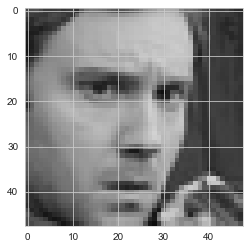

In [165]:
pix = np.fromstring(data_df.loc[0, 'pixels'], dtype=int, sep=' ')
#data_df.iloc[0]['pixels'].t
#pix = np.array(pix)
pix = pix.reshape(48,48,1)

pix = np.repeat(pix, 3, axis=-1)
plt.imshow(pix)

In [ ]:
from PIL import Image

new_image = Image.fromarray(np.array(X_train[0]))
new_image.save('new.png')

### Scale the data

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scal_X_train = scaler.fit_transform(X_train.reshape(-1, img_size*img_size))
scal_X_test = scaler.transform(X_test.reshape(-1, img_size*img_size))

In [ ]:
X_train = scal_X_train.reshape(-1, img_size, img_size, 1)
X_test = scal_X_test.reshape(-1, img_size, img_size, 1)

### Create images from list of pixels

In [ ]:
X_train[0]

In [ ]:
from PIL import Image

### Data Augmentation

**Baseline Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train)

rfc = RandomForestClassifier()
rfc.fit(X_train.reshape(X_train.shape[0], img_size*img_size), y_train_cat)

In [ ]:
rfc.score(X_test.reshape(X_test.shape[0], img_size*img_size), y_test_cat)

In [ ]:
X_train.shape

**Simple NN Model**

1. CNN 1D Kernel

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D())
model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='nadam',
    metrics=['accuracy'],
)
model.summary()

history = model.fit(X_train, y_train_cat, epochs=5, verbose=1, validation_split=0.25,
                    callbacks=[
                        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
                        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
                    ]
                   )

In [ ]:
fig, ax = plt.subplots()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

ax.plot(epochs, acc, label='Train Accuracy')
ax.plot(epochs, val_acc, label='Val Accuracy')

ax.legend();

2. CNN 2D Kernel

In [ ]:
model_Leaky = Sequential()
model_Leaky.add(Conv2D(filters=32, kernel_size=3, activation=layers.LeakyReLU(alpha=0.2), input_shape=(48, 48, 1)))
model_Leaky.add(MaxPooling2D())
model_Leaky.add(Conv2D(filters=32, kernel_size=3, activation=layers.LeakyReLU(alpha=0.2)))
model_Leaky.add(MaxPooling2D())
model_Leaky.add(Conv2D(filters=64, kernel_size=3, activation=layers.LeakyReLU(alpha=0.2), padding='same'))
model_Leaky.add(MaxPooling2D())
model_Leaky.add(Flatten())
model_Leaky.add(Dense(64, activation=layers.LeakyReLU(alpha=0.2)))
model_Leaky.add(Dense(3, activation='softmax'))

model_Leaky.compile(
    loss='categorical_crossentropy',
    optimizer='nadam',
    metrics=['accuracy'],
)
model_Leaky.summary()

history_Leaky = model_Leaky.fit(X_train, y_train_cat, epochs=5, verbose=1, validation_split=0.25,
                    callbacks=[
                        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
                        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
                        keras.callbacks.ModelCheckpoint('models/FER.{epoch:02d}-{val_loss:.2f}.hdf5', save_best_only=True)
                    ]
                   )

In [ ]:
fig, ax = plt.subplots()

acc = history_Leaky.history['accuracy']
val_acc = history_Leaky.history['val_accuracy']

epochs = range(len(acc))

ax.plot(epochs, acc, label='Train Accuracy')
ax.plot(epochs, val_acc, label='Val Accuracy')

ax.legend();

2D Kernel

In [ ]:
model_2D = Sequential()
model_2D.add(Conv2D(filters=32, kernel_size=(4,4), activation=layers.LeakyReLU(alpha=0.2), input_shape=(48, 48, 1)))
model_2D.add(MaxPooling2D(pool_size=(2,2)))
model_2D.add(Conv2D(filters=64, kernel_size=(4,4), activation=layers.LeakyReLU(alpha=0.2), padding='same'))
model_2D.add(MaxPooling2D(pool_size=(2,2)))
model_2D.add(Flatten())
model_2D.add(Dense(64, activation=layers.LeakyReLU(alpha=0.2)))
model_2D.add(Dense(3, activation='softmax'))

model_2D.compile(
    loss='categorical_crossentropy',
    optimizer='nadam',
    metrics=['accuracy'],
)
model_2D.summary()

history_2D = model_2D.fit(X_train, y_train_cat, epochs=10, verbose=1, validation_split=0.25,
                    callbacks=[
                        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
                        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
                        keras.callbacks.ModelCheckpoint('models_2D_leaky/FER.{epoch:02d}-{val_loss:.2f}.hdf5', save_best_only=True)

                    ]
                   )

In [ ]:
fig, ax = plt.subplots()

acc = history_2D.history['accuracy']
val_acc = history_2D.history['val_accuracy']

epochs = range(len(acc))

ax.plot(epochs, acc, label='Train Accuracy')
ax.plot(epochs, val_acc, label='Val Accuracy')

ax.legend();

In [ ]:
test_loss, test_acc = model_2D.evaluate(X_test, y_test_cat)

Base Model 2 

In [ ]:
model_leakyReku = Sequential()
model_leakyReku.add(Conv2D(32, (3, 3), activation=layers.LeakyReLU(alpha=0.2), input_shape=(48, 48, 1)))
model_leakyReku.add(MaxPooling2D(pool_size=(2,2)))
model_leakyReku.add(Dropout(0.25))
model_leakyReku.add(Conv2D(64, (3, 3), activation=layers.LeakyReLU(alpha=0.2), padding='same'))
model_leakyReku.add(MaxPooling2D(pool_size=(2,2)))
model_leakyReku.add(Dropout(0.25))
model_leakyReku.add(Flatten())
model_leakyReku.add(Dense(64, activation=layers.LeakyReLU(alpha=0.2)))
model_leakyReku.add(Dense(3, activation='softmax'))

model_leakyReku.compile(
    loss='categorical_crossentropy',
    optimizer='nadam',
    metrics=['accuracy'],
)

model_leakyReku.summary()

In [ ]:
model_leakyReku.fit(X_train, y_train_cat, epochs=1, verbose=1, validation_split=0.25)

In [ ]:
history = model_leakyReku.fit(X_train, y_train_cat, epochs=10, verbose=1, validation_split=0.25,
                    callbacks=[
                        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
                        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
                    ]
                   )

In [ ]:
test_loss, test_acc = model_leakyReku.evaluate(X_test, y_test_cat)

In [ ]:
pred_test_labesl = model_leakyReku.predict(X_test)

In [ ]:
model_.save('./base1')

In [ ]:
from keras.callbanks import ModelCheckpoint

checkpoint = ModelCheckpoint("model-weights.h5", monitor_'val_accuracy', vermose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

**Training a CNN with a Transferred Base**

In [ ]:
# def image_reshape(data):
#     image = np.reshape(data['images'].to_list(),(data.shape[0],48,48,1))
#     return image


# #train['pixels'] = train['pixels'].apply(pixels_to_array)
# X_train_new = image_reshape(train_df)


In [ ]:
X_train_new = np.repeat(X_train, 3, axis=-1)

In [ ]:
X_train_new.shape

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import ZeroPadding2D, Dropout 

base = VGG16(weights='imagenet', include_top=False, input_shape=(48,48,3))

# Freeze convolutional layers
for layer in base.layers:
    layer.trainable = False  

NN_transfer = Sequential(
                        [InputLayer(input_shape=X_train_new.shape[1:]),
                         base,
                         Flatten(),
                         Dense(1000, activation='relu'),
                         Dense(1000, activation='relu'),
                         Dense(3, activation='softmax')]
                       )

NN_transfer.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [ ]:
NN_transfer.fit(X_train_new, y_train_cat, epochs=1, verbose=True, validation_split=0.25,
                   callbacks=[
                            keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
                            keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
                        ]
               )

In [ ]:
history_transfer1 = NN_transfer.fit(X_train_new, y_train_cat, epochs=5, verbose=1, validation_split=0.25)

In [ ]:
accuracy_score(y_test, np.argmax(NN_transfer.predict(X_test), axis=-1))